# Trabajo Práctico 1: Propiedades en Venta

## Grupo 11 - "Los Outliers"

- Castillo, Carlos
- Destefanis, Juan Pablo
- Gómez, Celeste

In [578]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import geopandas as gpd
from shapely import wkt
from shapely.geometry import Point, Polygon

sns.set_theme()
sns.set_palette("colorblind")

caba_map = gpd.read_file('https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.geojson')
dataframe_original = pd.read_csv("https://drive.usercontent.google.com/download?id=1FnqM4GcZ-2O8QOHA3F2UpjKPxhmoPhgv")

# Análisis exploratorio y Preprocesamiento de Datos

## Exploración inicial

### Datos irrelevantes

Mantenemos un df de trabajo separado del original para mantener este último intacto.

In [579]:
df = dataframe_original

Y le echamos un vistazo rápido al dataset.

In [580]:
df.head()

id  start_date    end_date  created_on    latitud  \
0  XZq2dFGxBiboHY3Bo/tqlw==  2021-09-09  2022-01-27  2021-09-09 -38.957632   
1  8afoK+yMH/rnnlYiktwgNA==  2021-09-09  2021-10-23  2021-09-09 -34.888878   
2  iVaG5rBB47dd1Ya4BMXREA==  2021-09-09  2022-03-09  2021-09-09 -32.488717   
3  QE1QVMWKAHWkd0qT0FtPWA==  2021-09-09  2022-01-27  2021-09-09 -34.900165   
4  tJ5lSk7IysG/71OGhacNZA==  2021-09-09  2022-01-27  2021-09-09 -38.954528   

    longitud    place_l2 place_l3 place_l4 place_l5  place_l6 operation  \
0 -68.105443     Neuquén      NaN      NaN      NaN       NaN     Venta   
1 -56.092368  Montevideo      NaN      NaN      NaN       NaN     Venta   
2 -58.257499  Entre Ríos      NaN      NaN      NaN       NaN     Venta   
3 -54.808453   Maldonado      NaN      NaN      NaN       NaN     Venta   
4 -68.041862     Neuquén      NaN      NaN      NaN       NaN     Venta   

  property_type  property_rooms  property_bedrooms  property_surface_total  \
0          Casa             6.0                NaN                     NaN   
1          Casa             4.0                3.0                   193.0   
2          Casa             NaN                NaN                   110.0   
3          Casa             NaN                3.0                     NaN   
4            PH             3.0                2.0                     NaN   

   property_surface_covered  property_price property_currency  \
0                     206.0             NaN               NaN   
1                     193.0        390000.0               USD   
2                      45.0         47000.0               USD   
3                     180.0        400000.0               USD   
4                      98.0        102000.0               USD   

       property_title  
0      Casa - Capital  
1       Casa - Malvín  
2      Casa - Uruguay  
3    Casa - El Chorro  
4  PH - Villa Farrell

In [581]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460154 entries, 0 to 460153
Data columns (total 20 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   id                        460154 non-null  object 
 1   start_date                460154 non-null  object 
 2   end_date                  460154 non-null  object 
 3   created_on                460154 non-null  object 
 4   latitud                   419740 non-null  float64
 5   longitud                  419740 non-null  float64
 6   place_l2                  460154 non-null  object 
 7   place_l3                  437665 non-null  object 
 8   place_l4                  139020 non-null  object 
 9   place_l5                  2430 non-null    object 
 10  place_l6                  0 non-null       float64
 11  operation                 460154 non-null  object 
 12  property_type             460154 non-null  object 
 13  property_rooms            368498 non-null  f

Observando la información de la tabla, notamos que toda la columna `place_l6` solamente contiene datos nulos. Algo similar sucede en el caso de `place_l5`, donde un muy alto porcentaje de filas no tienen ningún valor en esta columa.

In [582]:
porcentaje_nulos_place_l5 = len(df[df["place_l5"].isna()]) / len(df) * 100
porcentaje_nulos_place_l6 = len(df[df["place_l6"].isna()]) / len(df) * 100

print("Porcenajes valores nulos por columna:\n")
print(f"place_l5: {round(porcentaje_nulos_place_l5, 2)}%")
print(f"place_l6: {porcentaje_nulos_place_l6}%")

Porcenajes valores nulos por columna:

place_l5: 99.47%
place_l6: 100.0%


Por lo tanto, se decidió eliminar ambas columnas.

In [583]:
df = df.drop(["place_l5", "place_l6"], axis="columns")

Los únicos registros de propiedades que nos interesa analizar son los que cumple con las siguientes condiciones:

- Sean casas, departamentos o PHs
- Se encuentren en Capital Federal
- Estén en venta
- Su precio se encuentre en USD (dolares estadounidenses).

Con esto en mente, las columnas que nos interesan para el filtrado son `operation`, que indica las que están en venta; `property_currency`, que sería la moneda usada en el anuncio; y `property_type`, que muestra el tipo de propiedad.

In [584]:
print("Valores únicos previos al filtrado:", end="\n\n")
print(f"operation: {df['operation'].unique()}")
print(f"property_currency: {df[df['property_currency'].notnull()]['property_currency'].unique()}")
print(f"property_type: {df['property_type'].unique()}")

Valores únicos previos al filtrado:

operation: ['Venta' 'Alquiler' 'Alquiler temporal']
property_currency: ['USD' 'UYU' 'ARS' 'PEN' 'COP']
property_type: ['Casa' 'PH' 'Departamento' 'Lote' 'Depósito' 'Otro' 'Local comercial'
 'Oficina' 'Casa de campo' 'Cochera']


In [585]:
df = df[
    (df['operation'] == 'Venta') &
    (df['property_type'].isin(['Casa', 'PH', 'Departamento']))
]

Filtrar por el tipo de propiedad y de operación es bastante directo. Sin embargo, con el tipo de moneda, barajamos dos opciones de cómo manejar las propiedades que no están ingresada en USD: se podrían convertir los precios de los anuncios que no estén en USD a esa moneda, o directamente se podrían descartar todos estos registros. Antes de tomar una decisión seguimos explorando los datos un poco más.

Primero observamos que todas las propiedades de interés ya son de operaciones del tipo venta, por lo que esta columna no aporta mucho valor al dataset filtrado. Debido a esto se decide eliminar la columna entera.

In [586]:
df['operation'].unique()

array(['Venta'], dtype=object)

In [587]:
df = df.drop("operation", axis="columns")

Procediendo con el filtrado por ubicación de la propiedad, vemos que hay varias columnas nos dan información de la misma. Con lo cual, para quedarnos solo con los anuncios de Capital Federal, tenemos que indagar un poco que muestran las columnas `place_lk`, siendo `K` los distintos números de las columnas.

Para ello, buscamos una muestra que nos permita ver que valores tienen estas columnas.

In [588]:
df[
    df['place_l2'].notnull() &
    df['place_l3'].notnull() &
    df['place_l4'].notnull()
][['place_l2', 'place_l3', 'place_l4']].sample(10)

place_l2             place_l3  \
429035    Bs.As. G.B.A. Zona Sur           Avellaneda   
81419     Bs.As. G.B.A. Zona Sur      Lomas de Zamora   
224215    Bs.As. G.B.A. Zona Sur             La Plata   
457156    Bs.As. G.B.A. Zona Sur             La Plata   
181288  Bs.As. G.B.A. Zona Norte  Malvinas Argentinas   
347986  Bs.As. G.B.A. Zona Oeste      Tres de Febrero   
151111  Bs.As. G.B.A. Zona Norte                Tigre   
449374  Bs.As. G.B.A. Zona Oeste               Moreno   
112108    Bs.As. G.B.A. Zona Sur             La Plata   
53081   Bs.As. G.B.A. Zona Oeste    General Rodríguez   

                          place_l4  
429035                  Avellaneda  
81419                    Temperley  
224215                    La Plata  
457156                   City Bell  
181288  Ingeniero Adolfo Sourdeaux  
347986                     Caseros  
151111                    Nordelta  
449374                      Trujui  
112108              José Hernández  
53081            General Rodríguez

En base a las muestras, apreciamos que a mayor `K`, mayor precisión en la ubicación. Capital Federal, siendo una zona muy extensa, está en las primera columna (`place_l2`). Las demás sirven para especificar barrio o región dentro de la ciudad en la que se encuentra cada propiedad.

In [589]:
df['place_l2'].value_counts()

place_l2
Capital Federal                 95543
Bs.As. G.B.A. Zona Norte        53222
Santa Fe                        31815
Bs.As. G.B.A. Zona Sur          30489
Bs.As. G.B.A. Zona Oeste        20483
Córdoba                         13362
Buenos Aires Costa Atlántica     8443
Neuquén                          4345
Buenos Aires Interior            3365
Montevideo                       3051
Mendoza                          3042
Río Negro                        2851
Maldonado                        2766
Tucumán                          2352
Colonia                          1022
Salta                             958
Entre Ríos                        728
San Luis                          473
San Juan                          470
Canelones                         442
La Pampa                          418
Florida                           366
Chubut                            274
Misiones                          260
Michigan                          243
Corrientes                        173
Juj

In [590]:
# Nos interesan únicamente las propiedades de Capital Federal
df = df[df['place_l2'] == 'Capital Federal']

De manera similar con como sucedió con la columna `operation`, luego de este último filtro, nos quedamos con propiedades cuyo `place_l2` únicamente toma el valor 'Capital Federal', por lo que eliminamos esta columna de valor único.

In [591]:
df["place_l2"].unique()

array(['Capital Federal'], dtype=object)

In [592]:
df = df.drop("place_l2", axis="columns")

Además, habiendo dejado únicamente `place_l3` y `place_l4` como variables de ubicación, vamos a renombrar estas mismas para darles nombres más significativos.

In [593]:
df = df.rename({"place_l3": "neighbourhood", "place_l4": "sub_neighbourhood"}, axis="columns")

Ya con las propiedades fuera de Capital Federal filtradas, notamos que entre las propiedades restantes, aquellas cuyos precios no están en USD representan un pequeño porcentaje del total. Por lo que decidimos optar por eliminar estos registros.

In [594]:
porcentaje_no_usd = len(df[df["property_currency"] != "USD"]) / len(df) * 100

print(f"Porcenajes monedas distintas de USD: {round(porcentaje_no_usd, 2)}%")

Porcenajes monedas distintas de USD: 1.35%


In [595]:
df = df[df['property_currency'] == 'USD']

Nuevamente nos quedamos con un valor único en esta columna, por lo que ya no nos aporta mucha información de interés, y decidimos eliminarla.

In [596]:
df["property_currency"].unique()

array(['USD'], dtype=object)

In [597]:
df = df.drop("property_currency", axis="columns")

Continuando con la examinación de las variables del tipo fecha, notamos que en varios de los samples observados, el valor de la columna `start_date` y `created_on` coinciden. Por lo que exploramos más de detalle para ver qué tipo de información continen estas columnas.

In [598]:
df[["start_date", "end_date", "created_on"]].sample(5)

start_date    end_date  created_on
284229  2021-02-24  2021-03-01  2021-02-24
194511  2021-11-02  2021-11-03  2021-11-02
431364  2021-12-16  2022-02-09  2021-12-16
384271  2021-09-06  2022-01-27  2021-09-06
181687  2021-08-06  2022-02-23  2021-08-06

In [599]:
df["start_date"].equals(df["created_on"])

True

Efectivamente para todos los registros los datos de estas dos columnas son los duplicados, por lo que decidimos prescindir de la columna `create_on`.

In [600]:
df = df.drop("created_on", axis="columns")

Finalmente, evaluamos que hacer con la variable `property_title` ya que sus valores eran en su mayoría valores arbitrarios.

In [601]:
df["property_title"].unique()

array(['VENTA CASA LLAVE EN MANO - COSTA ESMERALDA ',
       'VENTA TRES AMBIENTES LA BOCA PISO ALTO',
       'Departamento - 4 Ambientes - Catalinas Sur', ...,
       'Espectacular 4 amb130m2 con Balcon Terraza!!!',
       '3 ambientes con cochera listo para habitar!',
       'VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF C/ BALCÓN Vta Ata, PISO ALTO. BAJAS EXP. // APTO CRED.'],
      dtype=object)

Sin embargo, decidimos que podía aportar información importante a la hora de analizar outliers, así que momentáneamente la mantenemos.

Una vez hecho todo esto, echamos otros vistazo al dataframe ya procesado.

In [602]:
df.sample(5)

id  start_date    end_date    latitud  \
314761  GRJusifChhnJtO/kKmBuwQ==  2021-01-06  2021-03-18 -34.581869   
261957  PnZvmhblnPndGsk/Idz+UQ==  2021-11-06  2022-01-27 -34.591467   
454868  xr4RcBNrC0eRg6/6KivnrA==  2021-12-16  2022-02-09 -34.594285   
149704  ilaQsSdeDcT7r0fhVhdTgA==  2021-05-12  2021-06-05 -34.588669   
129278  cnKgfMaLLODcT1Ag/K/YFg==  2021-07-01  2021-07-02 -34.599659   

         longitud  neighbourhood sub_neighbourhood property_type  \
314761 -58.468334  Villa Ortuzar               NaN  Departamento   
261957 -58.377871         Retiro               NaN  Departamento   
454868 -58.445647   Villa Crespo               NaN  Departamento   
149704 -58.508235   Villa Devoto               NaN  Departamento   
129278 -58.375450  Puerto Madero               NaN  Departamento   

        property_rooms  property_bedrooms  property_surface_total  \
314761             3.0                2.0                    65.0   
261957             3.0                3.0                   251.0   
454868             6.0                4.0                   148.0   
149704             1.0                1.0                    40.0   
129278             3.0                2.0                    76.0   

        property_surface_covered  property_price  \
314761                      60.0        165000.0   
261957                     187.0        798000.0   
454868                     140.0        240000.0   
149704                      34.0         86000.0   
129278                      73.0        159000.0   

                                           property_title  
314761             Excelente 3 Ambientes en Villa Ortuzar  
261957  VENTA DEPARTAMENTO RETIRO . 251MTS2. 3 COCHERA...  
454868     DEPARTAMENTO  VILLA CRESPO 5 AMB MAS DEPENDENC  
149704    DEPARTAMENTO MONOAMBIENTE MUY LUMINOSO Y AMPLIO  
129278        VENTA 3 AMB RENOVADO A NUEVO FLORIDA AL 700

In [603]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 94249 entries, 25 to 460090
Data columns (total 14 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   id                        94249 non-null  object 
 1   start_date                94249 non-null  object 
 2   end_date                  94249 non-null  object 
 3   latitud                   90519 non-null  float64
 4   longitud                  90519 non-null  float64
 5   neighbourhood             93832 non-null  object 
 6   sub_neighbourhood         3643 non-null   object 
 7   property_type             94249 non-null  object 
 8   property_rooms            93205 non-null  float64
 9   property_bedrooms         83262 non-null  float64
 10  property_surface_total    89405 non-null  float64
 11  property_surface_covered  90895 non-null  float64
 12  property_price            94249 non-null  float64
 13  property_title            94249 non-null  object 
dtypes: float6

### Variable cuantitativas

Supuestos:
- Las unidades de medida de las variables `property_surface_total` y `property_surface_covered` son metros cuadrados.

Observamos las estadísticas de las columnas con datos cuantitativos.

In [604]:
df.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  90519.000000  90519.000000    93205.000000       83262.000000   
mean     -34.591481    -58.449795        2.822799           2.014629   
std        0.181719      0.292630        1.426148           1.129767   
min      -53.788624    -71.471192        1.000000          -1.000000   
25%      -34.615975    -58.466522        2.000000           1.000000   
50%      -34.595790    -58.439000        3.000000           2.000000   
75%      -34.577413    -58.408862        4.000000           3.000000   
max      -24.219827    -54.133330       40.000000          70.000000   

       property_surface_total  property_surface_covered  property_price  
count            89405.000000              90895.000000    9.424900e+04  
mean               109.092970                 87.931932    2.262382e+05  
std                980.401976                990.927129    3.186035e+05  
min                 10.000000                  1.000000    5.000000e+03  
25%                 45.000000                 40.000000    9.500000e+04  
50%                 65.000000                 58.000000    1.439000e+05  
75%                105.000000                 88.000000    2.370000e+05  
max             137000.000000             217000.000000    2.140000e+07

En base a estos datos, de inmediato se puede presentir la presencia de valores atípicos en todas las columnas de carácter numérico, salvo en longitud y latitud. Si observamos los máximos de las variables, vemos que estos valores están muy desviados de la media y del percentil 75% de sus respectivas variables.

Así mismo, si observamos los mínimos, notamos que en la columna `property_bedrooms` hay valores negativos, que claramente es un valor inválido, y también en la columna `property_rooms` el valor mínimo es solo 1, es decir, una propiedad que solo tiene 1 habitación. Optamos por interpretar este tipo de propiedades como un monoambiente.

También podemos notar que hay propiedades con superficies mayores a 100,000 metros cuadrados, lo que sería mayor al área que abarcan 14 campos de fútbol. Estos valores atípicos serán revisados con detenimiento más adelante, pero desde ya podemos intuir que estando en Capital Federal es díficil que estos valores sean correctos.

#### Correlación entre variables

Usamos un pairplot para empezar a ver las relaciones entre las distintas variables del dataset. Quitamos de este análisis la latitud y la longitud porque como refieren a coordenadas geográficas, sus valores numéricos no guardan relación lógica con el resto de los datos.

Text(0.5, 1, 'Relaciones entre variables antes de reparar')

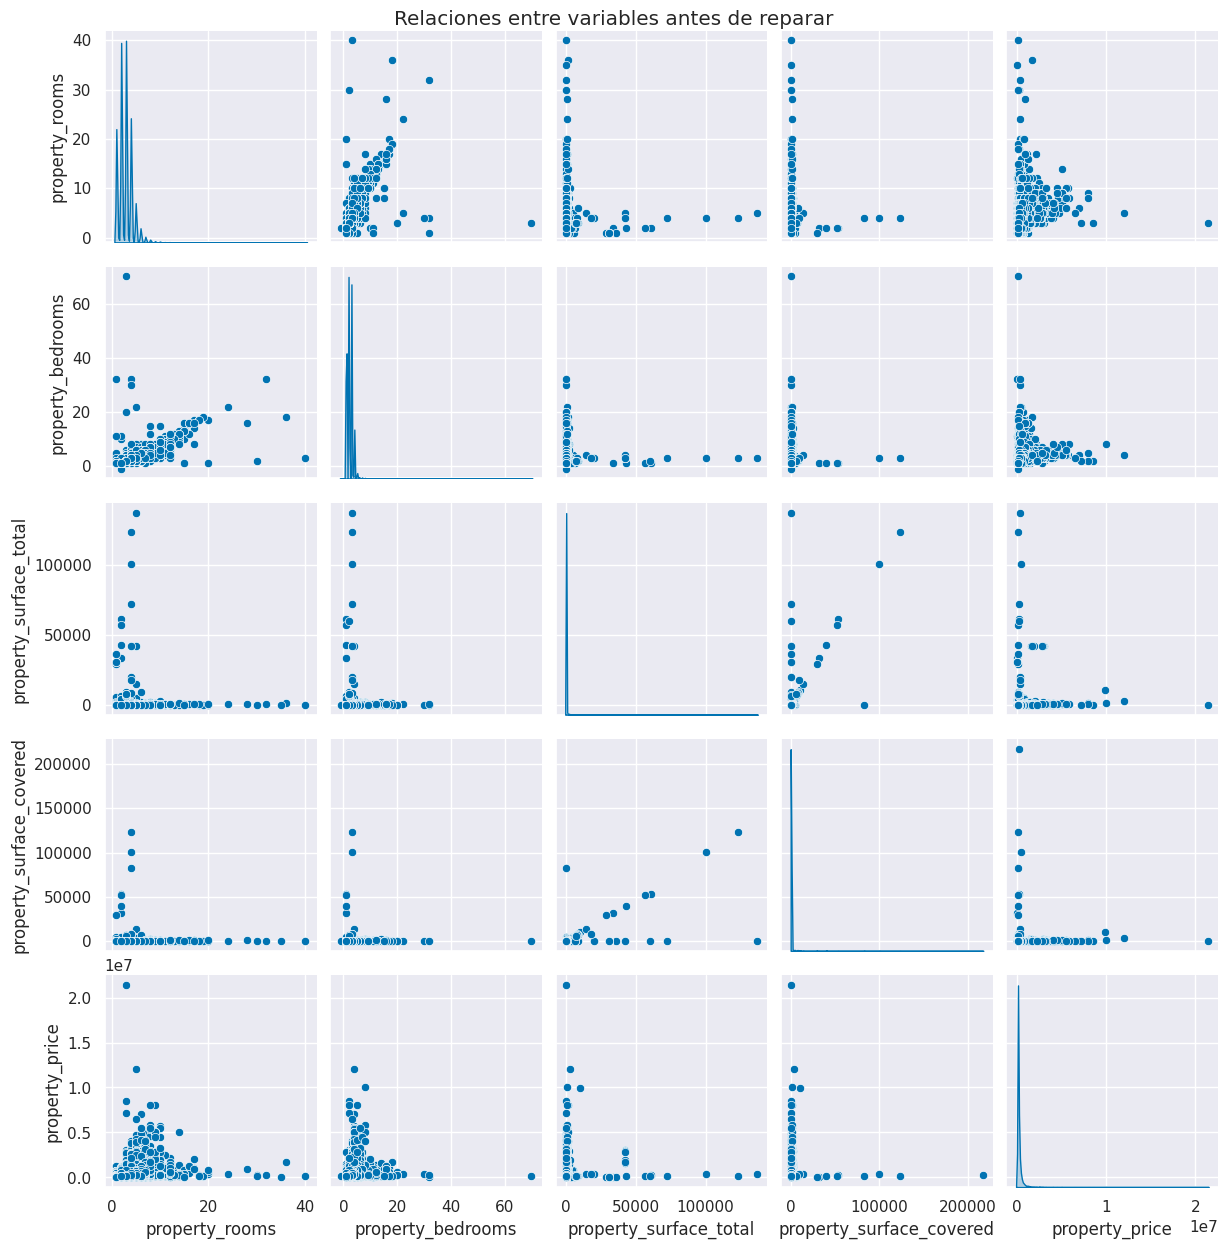

In [605]:
# Utilizamos un diagrama de distribución en vez de un histograma para reducir el tiempo de cómputo.
# Igualmente nos dan a entender la misma idea en este caso.
g = sns.pairplot(data=df.drop(["latitud", "longitud"], axis="columns"), diag_kind="kde")
g.fig.suptitle("Relaciones entre variables antes de reparar", y=1)

Llama la atención que varios de los gráficos de disperción entre variables son de "larga cola", lo que podría estar reafirmando la sospecha de la presencia de valores atípicos. Esto es especialmente evidente en los histogramas en la diagonal que grafican a cada variable consigo misma, donde pareciera haber un rango significativo de valores dispersos.

Analizamos la correlación entre variables utilizando el coeficiente de correlación de Pearson.

<Axes: title={'center': 'Correlación entre variables numéricas'}>

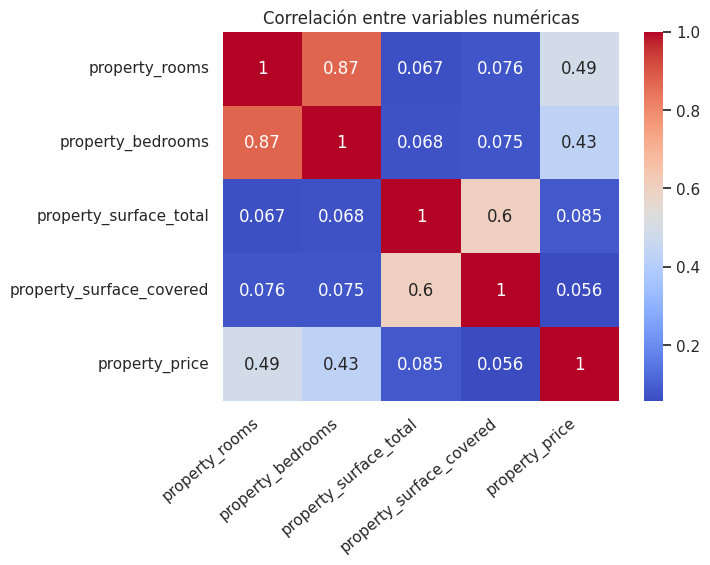

In [606]:
correlaciones = sns.heatmap(data=df.drop(["latitud", "longitud"], axis=1).select_dtypes("number").corr(), annot=True, cmap="coolwarm")
correlaciones.set(title="Correlación entre variables numéricas")
correlaciones.set_xticks(correlaciones.get_xticks()) # Evita un warning de Matplotlib con el siguiente comando.
correlaciones.set_xticklabels(correlaciones.get_xticklabels(), rotation=40, ha="right")

correlaciones

Lo más notorio en cuanto a correlaciones entre variables antes de hacer manejo de valores atípicos y datos nulos, es que relación entre las variables `property_rooms` y `property_bedrooms`. Es sensato pensar que las propiedades con más habitaciones tienen más cuartos y viceversa. Además, estas mismas dos variables son las que más se relacionan (linealmente) con el precio de la propiedad.

### Variable cualitativas

Las variables cualitativas con las que contamos son variables de texto y fecha. Son del tipo nominales, es decir, variables que pueden ser consideradas como opciones de categorías pero que no tienen un orden específico. Las columnas en cuestión son: `start_date`, `end_date`, `place_l3`, `place_l4` y `property_type`.

In [607]:
df.select_dtypes("object").drop("id", axis="columns")

start_date    end_date         neighbourhood sub_neighbourhood  \
25      2021-09-09  2021-09-26                   NaN               NaN   
42      2021-09-09  2021-09-26                  Boca               NaN   
43      2021-09-09  2021-09-28                  Boca               NaN   
49      2021-09-09  2022-01-05                  Once               NaN   
51      2021-09-09  2022-03-09                 Boedo               NaN   
...            ...         ...                   ...               ...   
460072  2021-01-05  2022-09-02      Villa del Parque               NaN   
460073  2021-01-05  2021-02-17      Villa del Parque               NaN   
460074  2021-01-05  2021-01-27      Villa del Parque               NaN   
460075  2021-01-05  2021-01-27      Villa del Parque               NaN   
460090  2021-01-05  2021-01-08  Centro / Microcentro               NaN   

       property_type                                     property_title  
25              Casa        VENTA CASA LLAVE EN MANO - COSTA ESMERALDA   
42      Departamento             VENTA TRES AMBIENTES LA BOCA PISO ALTO  
43      Departamento         Departamento - 4 Ambientes - Catalinas Sur  
49      Departamento                Venta departamento 4 ambientes Once  
51                PH                                         PH - Boedo  
...              ...                                                ...  
460072  Departamento      Espectacular 4 amb130m2 con Balcon Terraza!!!  
460073  Departamento        3 ambientes con cochera listo para habitar!  
460074  Departamento  VENTA MONOAMBIENTE CON PATIO SOL DE MAÑANA ///...  
460075  Departamento  VENTA MONOAMBIENTE APAISADO y DIVISIBLE AL CF ...  
460090  Departamento               VENTA DEPTO 2 1/2 AMBIENTES - CENTRO  

[94249 rows x 6 columns]

Examinando las variables del tipo fecha podemos observar que tenemos 365 fechas únicas. Todas son del año 2021, lo que significa que hubieron nuevas propiedades enlistadas para venta todos los días del año.

In [608]:
print(f"Cantidad fechas únicas: {len(df['start_date'].unique())}")

Cantidad fechas únicas: 365


In [609]:
pd.to_datetime(df["start_date"]).apply(lambda x: x.year).unique()

array([2021])

Sin embargo, con los valores de la variable `end_date` hay un rango de fechas mucho más amplio, en el que incluso llegamos a encontrar fechas del año 9999.

In [610]:
df[df["end_date"].str.contains("9999")]["end_date"]

1233      9999-12-31
1471      9999-12-31
1495      9999-12-31
1520      9999-12-31
1932      9999-12-31
             ...    
460015    9999-12-31
460019    9999-12-31
460020    9999-12-31
460028    9999-12-31
460065    9999-12-31
Name: end_date, Length: 5041, dtype: object

Interpretamos estos valores como registros que todavía seguían listados al momento de generar el dataset, es decir, propiedades que todavía no se habían vendido. La gran cantidad de casos en los que pasa esto descarta posibles errores en el ingreso de esos datos.

En cuanto los valores de la variable `barrio`, podemos observar los valores posibles y sus frecuencias:

In [611]:
df["neighbourhood"].value_counts()

neighbourhood
Palermo                 14308
Belgrano                 8898
Caballito                7168
Recoleta                 6282
Villa Urquiza            4673
Almagro                  4081
Nuñez                    3546
Villa Crespo             3189
Flores                   3110
Barrio Norte             2975
Balvanera                2553
Colegiales               1951
Villa Devoto             1921
Villa del Parque         1829
Saavedra                 1829
Puerto Madero            1493
San Telmo                1380
San Cristobal            1300
San Nicolás              1295
Retiro                   1250
Barracas                 1246
Boedo                    1237
Floresta                 1195
Monserrat                1115
Parque Chacabuco         1073
Villa Pueyrredón         1011
Coghlan                   984
Villa Luro                727
Mataderos                 719
Chacarita                 697
Liniers                   668
Villa Ortuzar             662
Parque Patricios          

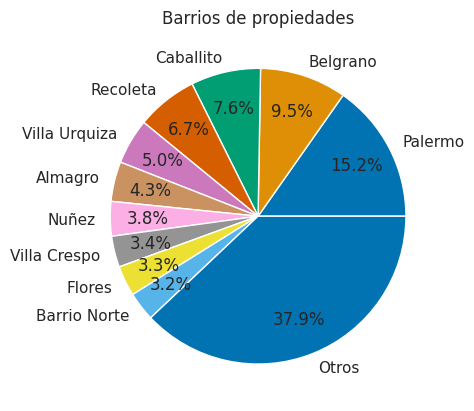

In [612]:
def distribucion_barrios(df, n_barrios, title=''):
  frecuencias_barrios = df["neighbourhood"].value_counts().sort_values(ascending=False)

  barrios_mas_comunes = frecuencias_barrios.iloc[:n_barrios]
  barrios_mas_comunes["Otros"] = frecuencias_barrios.iloc[n_barrios:].sum()

  plt.pie(barrios_mas_comunes, labels=barrios_mas_comunes.index,
          autopct="%1.1f%%", pctdistance=0.75)
  plt.title(label=title)

distribucion_barrios(df, 10, "Barrios de propiedades")

En cuanto a los sub-barrios podemos ver que solamente aquellas propiedades que se encuentran en Palermo tienen información sobre el subbarrio en el que se encuentran.

In [613]:
sub_barrios = df[df["sub_neighbourhood"].notnull()]["sub_neighbourhood"].value_counts()
sub_barrios

sub_neighbourhood
Palermo Hollywood    1576
Palermo Chico        1092
Palermo Soho          804
Palermo Viejo         171
Name: count, dtype: int64

In [614]:
porcentaje_con_sub_barrios = sub_barrios.sum() / len(df) * 100

print(f"Porcentaje propiedades con sub-barrio: {round(porcentaje_con_sub_barrios, 2)}%")

Porcentaje propiedades con sub-barrio: 3.87%


Finalmente, si analizamos el campo `property_type` que filtramos anteriormente para solo tener propiedades de los tipos 'Casa', 'PH' o 'Departamento' tiene las siguientes métricas:

In [615]:
df["property_type"].value_counts()

property_type
Departamento    80829
PH               9266
Casa             4154
Name: count, dtype: int64

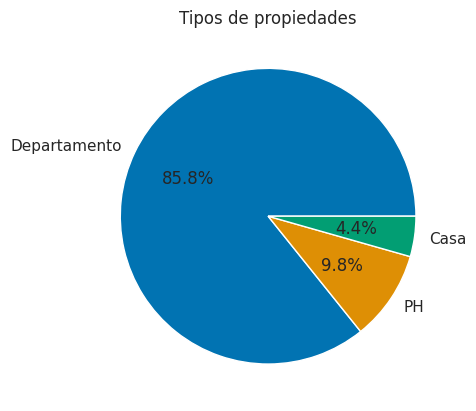

In [616]:
def distribucion_property_type(df, title=''):
  property_types = df["property_type"].value_counts()

  plt.pie(property_types, labels=property_types.index,
          autopct="%1.1f%%")
  plt.title(label=title)

distribucion_property_type(df, "Tipos de propiedades")

## Limpieza de datos

Guardamos una copia del dataset antes de lidiar con los datos nulos y outliers para posteriormente comparar la distribución y estadísticas del mismo con la versión resultante de los procesos de limpieza.

In [617]:
df_pre_limpieza = df.copy()

In [618]:
len(df)

94249

Observamos los porcentajes de datos nulos por columna:

In [619]:
porcentajes_nulos = df.isna().sum() / len(df) * 100
porcentajes_nulos = porcentajes_nulos[porcentajes_nulos > 0]
porcentajes_nulos

latitud                      3.957602
longitud                     3.957602
neighbourhood                0.442445
sub_neighbourhood           96.134707
property_rooms               1.107704
property_bedrooms           11.657418
property_surface_total       5.139577
property_surface_covered     3.558658
dtype: float64

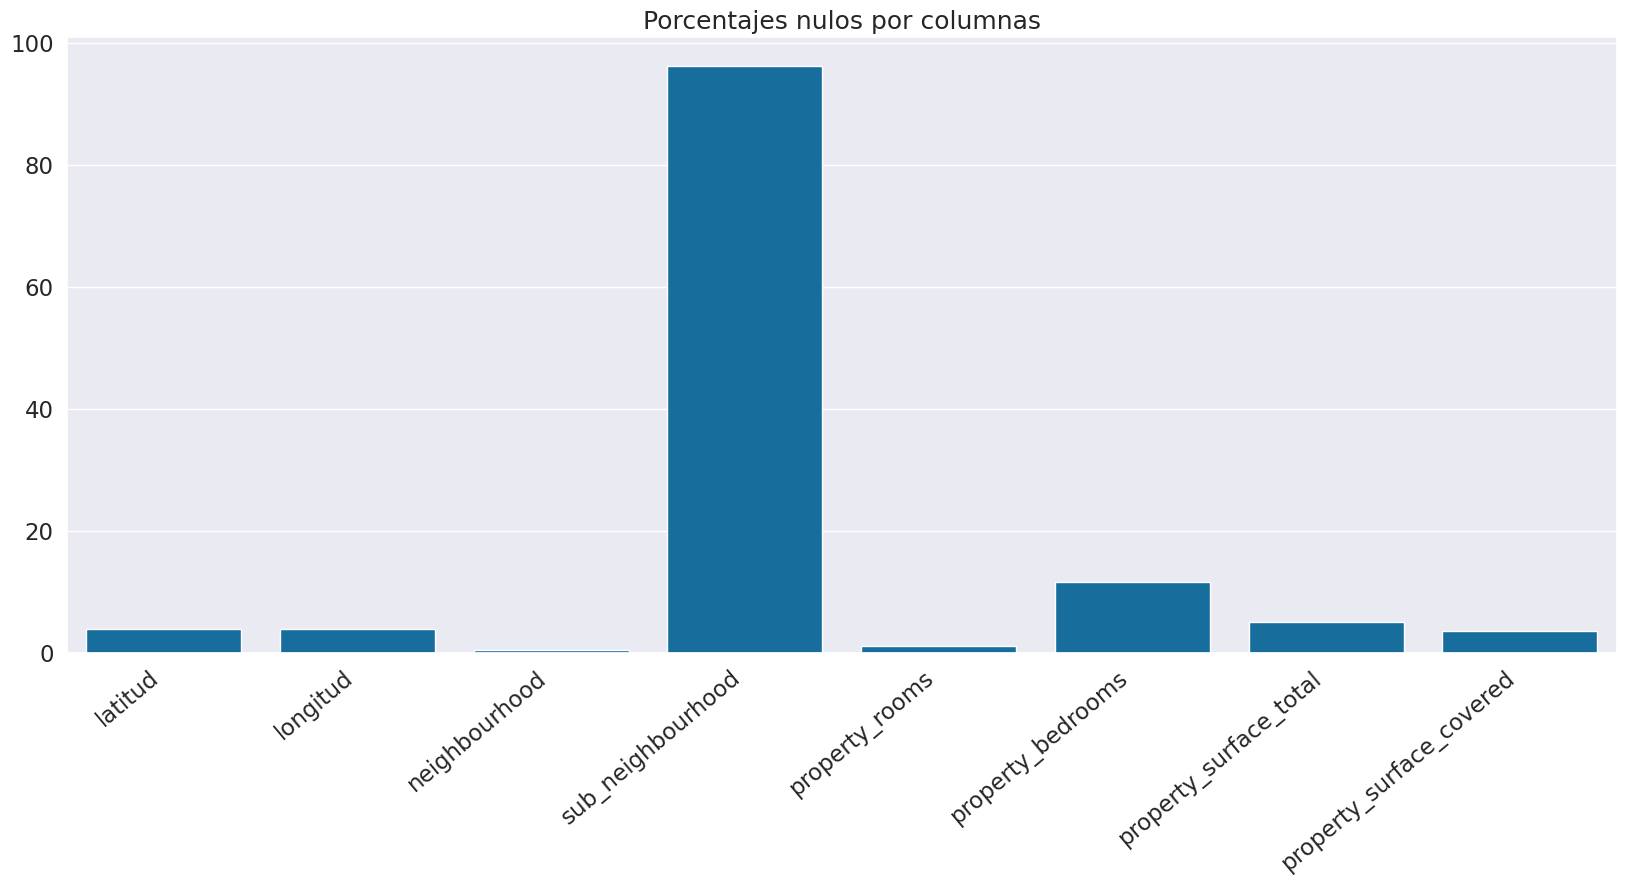

In [620]:
plt.figure(figsize=(20,8))
with sns.plotting_context("notebook", font_scale=1.5):
  porcentajes_nulos_grafico = sns.barplot(porcentajes_nulos)
  porcentajes_nulos_grafico.set(title="Porcentajes nulos por columnas")
  porcentajes_nulos_grafico.set_xticks(porcentajes_nulos_grafico.get_xticks()) # Evita un warning de Matplotlib con el siguiente comando.
  porcentajes_nulos_grafico.set_xticklabels(porcentajes_nulos_grafico.get_xticklabels(), rotation=40, ha="right")

Podríamos analizar lo mismo pero a nivel de fila, es decir, determinar cuántas filas tienen solo 1 columna nula, cuántas tiene 2, cuántas tiene todas las columnas nulas, etc.

In [621]:
porcentajes_nulos_por_fila = df.isna().sum(axis="columns").value_counts() / len(df) * 100
porcentajes_nulos_por_fila

1    75.502127
2    16.618744
3     4.359728
0     2.568728
4     0.727859
5     0.112468
6     0.109285
7     0.001061
Name: count, dtype: float64

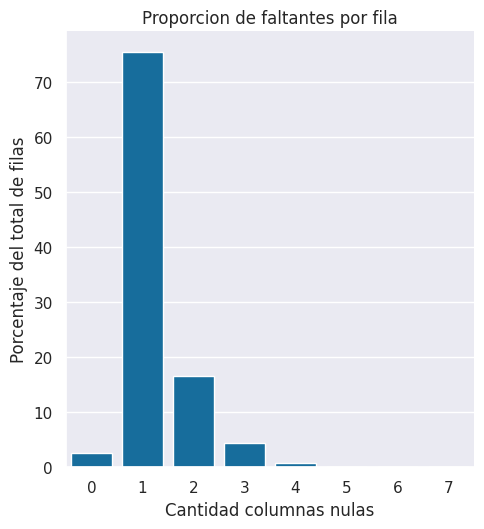

In [622]:
fig = sns.catplot(data=porcentajes_nulos_por_fila, kind="bar").set(xlabel="Cantidad columnas nulas",
                                                            ylabel="Porcentaje del total de filas")
fig.set(title="Proporcion de faltantes por fila")
plt.show()

Es decir, que la mayoría de los registros que contienen columnas nulas tiene solamente 1 columna nula.

#### Barrios

Sabemos de los análisis anteriores que un alto porcentaje de propiedades tienen solamente 1 columna con datos nulos, y que a la vez, muchos registros tienen la columna `sub_neighbourhood` también sin datos, por lo que podríamos ver si este alto porcentaje de registros con solo 1 columna nula se debe a sus valores para este último campo.

In [623]:
cantidad_con_1_col_nula = df.isna().sum(axis="columns").value_counts()[1]
cantidad_solo_sub_neighbourhood_nulo = len(df[
    (df.isna().sum(axis="columns") == 1) &
    (df["sub_neighbourhood"].isna())
])

print(f"Porcentaje con solo `sub_neighbourhood` nulo: {round(cantidad_solo_sub_neighbourhood_nulo / cantidad_con_1_col_nula * 100, 2)}%")

Porcentaje con solo `sub_neighbourhood` nulo: 98.99%


Efectivamente, casi el 99% de los registros a los que les falta solo una feature (conjunto que a su vez representa al casi 75% de los registros con nulos totales) son propiedades que no tienen información sobre el sub-barrio en el que se encuentran. Debido a esto, decidimos eliminar esta columna también.

In [624]:
df = df.drop("sub_neighbourhood", axis="columns")

Por otra parte, el poncentaje de propiedades que no tienen información de su barrio es bajo. Sabiendo que tenemos información sobre la latitud y longitud de las mismas, podríamos completar la información del barrio que falta en una propiedad si contamos con sus coordenadas. Para esto vamos a utilizar la información provista por el Gobierno de la Ciudad mediante [este dataset](https://data.buenosaires.gob.ar/dataset/barrios) y aplicar la técnica Cold-Deck.

In [625]:
barrios = pd.read_csv("https://cdn.buenosaires.gob.ar/datosabiertos/datasets/ministerio-de-educacion/barrios/barrios.csv", delimiter=";")[["BARRIO", "WKT"]]
barrios["WKT"] = barrios["WKT"].apply(wkt.loads)

barrios = gpd.GeoDataFrame(barrios, geometry="WKT").rename({"BARRIO": "neighbourhood"}, axis="columns")

Tenemos que cambiar los nombres de los barrios en el dataset del gobierno para que coincidan con los nombres de los barrios que ya tenemos, para que no se introduzcan nuevas variantes para esta categoría cuando se está intentando representar el mismo barrio.

In [626]:
barrios["neighbourhood"] = barrios["neighbourhood"].apply(lambda x: x.title())

barrios_gcba = set(barrios["neighbourhood"].unique())
barrios_properati = set(df[df["neighbourhood"].notnull()]["neighbourhood"].unique())

display(barrios_properati.difference(barrios_gcba)) # Están en el ds de Properati pero no en el de GCBA
display(barrios_gcba.difference(barrios_properati)) # Están en el ds de GCBA pero no en el de Properati

{'Abasto',
 'Agronomía',
 'Barrio Norte',
 'Catalinas',
 'Centro / Microcentro',
 'Congreso',
 'Constitución',
 'Las Cañitas',
 'Once',
 'Parque Centenario',
 'Pompeya',
 'San Nicolás',
 'Tribunales',
 'Villa General Mitre',
 'Villa Pueyrredón',
 'Villa del Parque'}

{'Agronomia',
 'Constitucion',
 'Nueva Pompeya',
 'San Nicolas',
 'Villa Del Parque',
 'Villa Gral. Mitre',
 'Villa Pueyrredon'}

In [627]:
barrios["neighbourhood"] = barrios["neighbourhood"].replace({
  "Agronomia": "Agronomía",
  "Constitucion": "Constitución",
  "San Nicolas": "San Nicolás",
  "Villa Del Parque": "Villa del Parque",
  "Villa Gral. Mitre": "Villa General Mitre",
  "Villa Pueyrredon": "Villa Pueyrredón"
})

In [628]:
from shapely.geometry import Point

def asignar_barrio(propiedad):
  latitud, longitud = propiedad["latitud"], propiedad["longitud"]
  barrios.contains(Point(longitud, latitud))
  try:
    propiedad["neighbourhood"] = barrios[barrios.contains(Point(longitud, latitud))]["neighbourhood"].iloc[0]
  except IndexError:
    pass

  return propiedad

In [629]:
df = df.apply(lambda p: p if not pd.isna(p["neighbourhood"]) else asignar_barrio(p), axis="columns")

Luego de aplicar la técnica de Cold-Deck, vemos que aún nos queda ciertas filas con barrios nulos. Con lo cual, procedemos a ver cuantas de esas filas tampoco tienen coordenadas válidas.

In [630]:
df['neighbourhood'].isna().value_counts()

neighbourhood
False    93883
True       366
Name: count, dtype: int64

In [631]:
len(df[df['neighbourhood'].isna() & ((df['latitud'].isna()) | (df['longitud'].isna()))])

170

De las 366 filas que no tienen barrio, 170 tampoco tienen longitud o latitud, por lo que decidimos dropearlas.

In [632]:
porcentajes_nulos_neighbourhood = df['neighbourhood'].isna().sum() / len(df) * 100
porcentajes_nulos_neighbourhood

0.3883330327112224

In [633]:
df = df.dropna(subset=['neighbourhood'])

Sin embargo, todavía nos quedan algunas propiedades que tienen información del barrio, pero no tienen información de su latitud ni longitud. Lo que vamos a hacer para estas propiedades es ubicarlas en el centro de sus respectivos barrios.

In [634]:
cantidad_sin_coords = len(df[(df['latitud'].isna() | df['longitud'].isna())])
print("Cantidad con barrios sin coordenadas antes de Cold-Deck:", cantidad_sin_coords)

Cantidad con barrios sin coordenadas antes de Cold-Deck: 3560


In [635]:
barrios_con_centro = barrios.copy()
barrios_con_centro["centro"] = barrios.centroid

def asignar_coordenadas(propiedad):
  barrio = propiedad["neighbourhood"]

  try:
    centro = barrios_con_centro[barrios_con_centro["neighbourhood"] == barrio]["centro"]
    propiedad["latitud"], propiedad["longitud"] = centro.get_coordinates().values[0]
  except IndexError:
    pass

  return propiedad

In [636]:
df = df.apply(lambda p: asignar_coordenadas(p) if pd.isna(p["latitud"]) or pd.isna(p["longitud"]) else p, axis="columns")

Sin bien no se logró encontrar el centro de coordenadas de todos los barrios de las propiedades de Properati, se redujo la cantidad de registros con latitud y longitud nulos de 3560 a 309, lo cual es una reducción significativa.

In [637]:
cantidad_sin_coords = len(df[(df['latitud'].isna() | df['longitud'].isna())])
print("Cantidad con barrios sin coordenadas después de Cold-Deck:", cantidad_sin_coords)

Cantidad con barrios sin coordenadas después de Cold-Deck: 309


Si observamos algunos de los nombres de los barrios de las propiedades a las que no se les pudo asignar coordenadas, podemos observar que son nombres de subbarrios en vez de nombres oficiales de barrios reconocidos por el Gobierno de la Ciudad. Podríamos haber asignado a estos subbarrios las coordenadas de sus verdaderos barrios o haberles cambiado el nombre para unificarlos con los mismo, pero debido a que el número de propiedades es muy bajo en comparación con las propiedades a las que sí se les asignó un centro de coordenadas, decidimos mejor dropear estas faltantes.

In [638]:
df[(df["latitud"].isna()) | (df["longitud"].isna())]["neighbourhood"].value_counts()

neighbourhood
Barrio Norte            185
Congreso                 39
Once                     36
Tribunales               32
Abasto                   12
Pompeya                   3
Parque Centenario         1
Centro / Microcentro      1
Name: count, dtype: int64

In [639]:
df = df.dropna(subset=["longitud", "latitud"])

#### Áreas

Examinamos que sucede con las propiedades que no tienen `property_surface_total` ni `property_surface_covered`. Los porcentajes de registros que tienen nulo alguna de estas dos columnas son 5.09% y 3.56% respectivamente.

In [640]:
porcentaje_surface_total_na = round(len(df[df['property_surface_total'].isna()]) / len(df) * 100, 2)
porcentaje_surface_surface_na = round(len(df[df['property_surface_covered'].isna()]) / len(df) * 100, 2)

porcentaje_surface_total_na, porcentaje_surface_surface_na

(5.09, 3.56)

Optamos por utilizar la técnica MICE para completar los valores faltantes de estas dos columnas.

Outliers de `surface_total` y `surface_covered` antes de imputar.

In [641]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_surfaces = IterativeImputer(random_state=0)
df_impt_default = df.copy()
df_impt_default.loc[:, ["property_surface_total", "property_surface_covered"]] = impute_surfaces.fit_transform(df_impt_default[["property_surface_total", "property_surface_covered"]])

Viendo los outliers que tenemos ahora

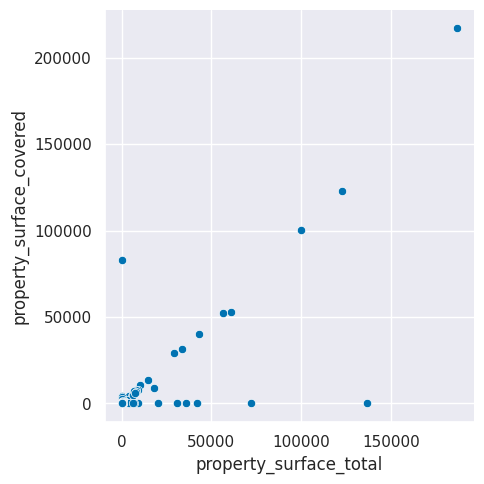

In [642]:
sns.relplot(data=df_impt_default, x="property_surface_total", y="property_surface_covered", kind="scatter")

Probamos cambiando la cantidad de iteraciones

In [643]:
impute_surfaces = IterativeImputer(random_state=0, max_iter=20, initial_strategy='most_frequent')
df_impt_median_20iter = df.copy()
df_impt_median_20iter.loc[:, ["property_surface_total", "property_surface_covered"]] = impute_surfaces.fit_transform(df_impt_median_20iter[["property_surface_total", "property_surface_covered"]])

Tras la imputación, vemos como nos quedan los outliers de ambas variables.

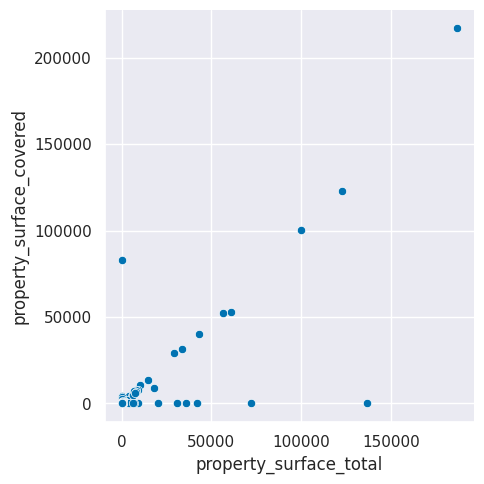

In [644]:
sns.relplot(data=df_impt_median_20iter, x="property_surface_total", y="property_surface_covered", kind="scatter")

Visualmente notamos que no hay muchas diferencias entre ambos métodos de imputación, por lo que otpamos por quedarnos con los valores del algoritmo MICE por defecto.

In [645]:
df = df_impt_default

### Imputación con MICE

Nuevamente, utilizamos el método de imputación MICE.

In [646]:
cantidad_rooms_na = len(df[df["property_rooms"].isna()])
cantidad_bedrooms_na = len(df[df["property_bedrooms"].isna()])

print("Cantidad con `property_rooms` nulo:", cantidad_rooms_na)
print("Cantidad con `property_bedrooms` nulo:", cantidad_bedrooms_na)

Cantidad con `property_rooms` nulo: 955
Cantidad con `property_bedrooms` nulo: 10871


In [647]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

impute_rooms = IterativeImputer(random_state=0)
df.loc[:, ["property_rooms", "property_bedrooms"]] = impute_rooms.fit_transform(df[["property_rooms", "property_bedrooms"]])

Luego de imputar las filas nulas, tenemos que tomar en cuenta que los valores de estas columnas deben ser valores enteros, entonces decidimos redondear hacia arriba los valores flotantes que produjo la imputación.

In [648]:
df[["property_rooms", "property_bedrooms"]] = df[["property_rooms", "property_bedrooms"]].transform(np.ceil)

Analizamos las estadísticas de ambas variables luego de la imputación.

In [649]:
df[["property_rooms", "property_bedrooms"]].describe()

property_rooms  property_bedrooms
count    93574.000000       93574.000000
mean         2.833212           1.916398
std          1.431429           1.116296
min          1.000000          -1.000000
25%          2.000000           1.000000
50%          3.000000           2.000000
75%          4.000000           3.000000
max         40.000000          70.000000

Podemos ver que hay algunas propiedades con cantidad de cuartos negativa, lo cual probablemente sea un error de tipeo por lo que su valor de `property_rooms` se asemeja a un valor esperable para una propiedad de 1 bedroom (que es el mismo valor ingresado pero sin el signo negativo). Además la descripción de esta propiedad indica que es un tres ambientes, por lo que los valores de 2 rooms y 1 bedroom encajan a la perfección. Decidimos corregirlo y mantener la fila.

In [650]:
df[df["property_bedrooms"] == -1][["property_rooms", "property_bedrooms", "property_title"]]

property_rooms  property_bedrooms  \
406880             2.0               -1.0   

                                           property_title  
406880  Jardines de Roosevelt - Hermoso 3 ambientes co...

In [651]:
df.loc[406880, "property_bedrooms"] = 1

## Outliers Multivariados

Optamos por utilizar el método Local Outlier Factor para analizar los outliers multivariados. Este modelo determina la ubicación de zonas donde la densidad de muestras sea relativamente baja, es decir, zonas donde haya pocas muestras aisladas.

Decidimos probar con diferentes valores de los parámetros del algoritmo para quedarnos con la opción que tenga mejor rendimiento en el conjunto total.

In [652]:
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV
from sklearn.neighbors import LocalOutlierFactor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

X = df.drop(["id", "start_date", "end_date", "latitud", "longitud", "property_title"], axis="columns")

ct = ColumnTransformer([
    ("scaling", StandardScaler(), X.select_dtypes(include="number").columns)
], remainder="passthrough")


X_trans = pd.get_dummies(X, columns=["neighbourhood", "property_type"])
X_trans = ct.fit_transform(X_trans)

params = {
    "leaf_size": [10, 20, 30, 40, 50],
    "metric": ["minkowski", "euclidean", "manhattan"]
}

def custom_scoring(estimator, X):
  return -estimator.fit(X).negative_outlier_factor_.mean()

anom_detector = HalvingGridSearchCV(
    estimator=LocalOutlierFactor(),
    param_grid=params,
    scoring=custom_scoring,
    verbose=2,
)

Para entrenar al modelo utilizamos el método fit con el set de entrenamiento ya transformado (en este caso al ser un modelo de clustering no necesitamos labels):

```python
anom_detector.fit(X_trans)
```

Sin embargo, luego de haber ejecutado este método con anterioridad, ya contamos con el modelo más óptimo encontrado, que ha sido exportado en un archivo de joblib, lo que nos permite simplemente cargar el archivo y no tener que volver a entrenar todos los modelos con todos los parámetros que probamos.

In [653]:
from joblib import load

lof = load("lof.joblib")
lof.get_params()

{'algorithm': 'auto',
 'contamination': 'auto',
 'leaf_size': 40,
 'metric': 'manhattan',
 'metric_params': None,
 'n_jobs': None,
 'n_neighbors': 20,
 'novelty': False,
 'p': 2}

También corrimos el modelo de detección de anomalías sobre el dataset original, pero dado a que esto también tomaba un tiempo decidimos exportarlo para luego no tener que volver a ejecutarlo.

Importamos los datos de los outliers.

In [654]:
with open('outliers.npy', 'rb') as f:
  y_pred = np.load(f)
y_pred

array([ 1,  1, -1, ...,  1,  1, -1])

Contamos los valores, donde 1 indica que no es outlier, mientras que -1 significa que el dato es un outlier.

De aca vemos que hay 10968 outliers.

In [655]:
y = pd.Series(y_pred)
y.value_counts()

 1    82606
-1    10968
Name: count, dtype: int64

Dropeamos todos los outliers detectados por el modelo de Local Outlier Factor entrenado previamente.

In [656]:
df = df.drop(index=df.iloc[(np.where(y == -1)[0])].index)

## Outliers Univariados

#### Areas

Visualizamos un scatter plot de las dos áreas para ver si podemos identificar outliers visualmente.

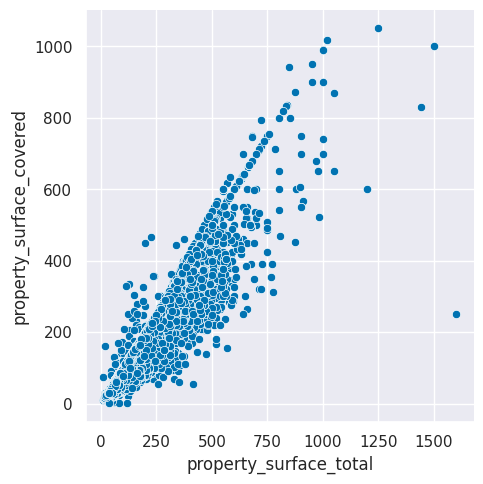

In [657]:
sns.relplot(data=df, x="property_surface_total", y="property_surface_covered", kind="scatter")

De este gráfico logramos identificar un outlier con superficie total mayor a 1500, por lo que vamos a analizarlo.

In [658]:
df[df["property_surface_total"] > 1500]

id  start_date    end_date    latitud   longitud  \
40290  N0kzILcFlovytAwyaeZu7A==  2021-07-19  9999-12-31 -34.662911 -58.514027   

      neighbourhood property_type  property_rooms  property_bedrooms  \
40290     Mataderos          Casa             8.0                6.0   

       property_surface_total  property_surface_covered  property_price  \
40290                  1600.0                     250.0        295000.0   

         property_title  
40290  Casa - Mataderos

In [659]:
df = df.drop(df[df["property_surface_total"] > 1500].index)

Ahora procedemos a enfocarnos en los outliers propios de cada variable.

Para esto, mejor utilizamos gráficos de caja para entender mejor cómo los outliers se comparan con las métricas de los demás valores de sus respectivas variables.

[Text(0.5, 1.0, 'Boxplot de superficie cubierta')]

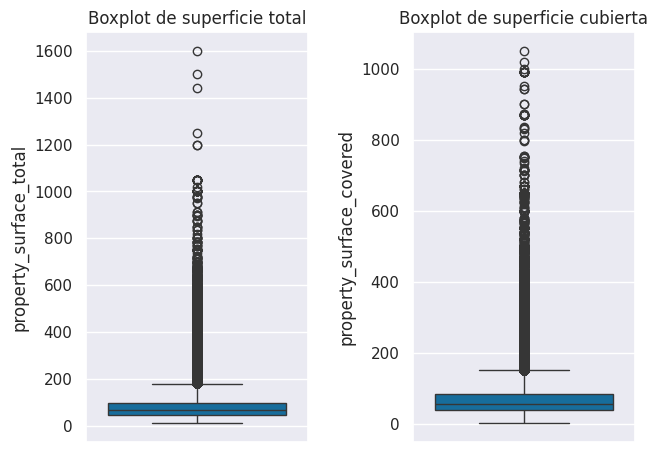

In [529]:
fig, ax = plt.subplots(1, 2)
fig.tight_layout(w_pad=3)

sns.boxplot(y=df['property_surface_total'], ax=ax[0]).set(title="Boxplot de superficie total")
sns.boxplot(y=df['property_surface_covered'], ax=ax[1]).set(title="Boxplot de superficie cubierta")

Analizamos las estadísticas de estas variables para tener más información.

De ellas logramos identificar que el mínimo para la variable `property_surface_covered` resulta de 1 metro cuadrado, lo cual resulta algo bastante extraño.

In [530]:
df[["property_surface_total", "property_surface_covered"]].describe()

property_surface_total  property_surface_covered
count            82606.000000              82606.000000
mean                87.855761                 75.980514
std                 77.617555                 65.555462
min                 10.000000                  1.000000
25%                 45.000000                 40.000000
50%                 65.000000                 56.000000
75%                 99.068401                 84.000000
max               1600.000000               1050.000000

En base a los boxplots, podemos ver que hay un conjunto de propiedades que tiene sus valores de superficie particularmente altos, así que echamos un vistazo a las propiedades con `property_surface_total` y `property_surface_covered` más altos.

Del mismo modo, desviamos nuestra atención al outliers más lejano de `property_surface_covered`.

In [532]:
df[df["property_surface_covered"] == df["property_surface_covered"].max()]

id  start_date    end_date    latitud  \
349665  nQakMaQUlPdJOAZHYCobaw==  2021-04-16  2021-06-05 -58.450241   

         longitud neighbourhood property_type  property_rooms  \
349665 -34.554763      Belgrano          Casa             8.0   

        property_bedrooms  property_surface_total  property_surface_covered  \
349665                6.0                  1250.0                    1050.0   

        property_price         property_title  
349665       3500000.0  Casa - Belgrano Chico

De aquí podemos concluir que este extremo parece razonable, por lo que optamos por no dropearlo.

Los demás outliers de esta variable se encuentran más cercanos al resto del conjunto de valores de esta variable, por lo que no los examinamos de manera individual.

Observamos que algunos de estas propiedades que tienen más superficie cubierta que superficie total. Esto sería un error lógico, por lo que consideramos todas las propiedades que tienen esta condición como outliers. Investigamos qué otras propiedades tienen esta condición.

In [533]:
mas_surface_covered_que_total = df[df["property_surface_covered"] > df["property_surface_total"]]
len(mas_surface_covered_que_total)

1118

Valoramos volver a imputar el valor de la variable `property_surface_covered` con el de `property_surface_total`, para que las propiedades que tienen esta condición, tuvieran igual valor en ambas variables, pero finalmente decidimos dropearlas todas, ya que de hacer esto, estaríamos asumiendo esta igualdad sin fundamento, ya que las demás variables no nos dan información al respecto.

In [534]:
df = df.drop(mas_surface_covered_que_total.index)

Ahora analizamos las que tienen solamente 1 metro cuadrado cubierto.

In [535]:
df[df["property_surface_covered"] == 1][["property_rooms", "property_bedrooms", "property_surface_total", "property_surface_covered", "property_title"]]

property_rooms  property_bedrooms  property_surface_total  \
7869               2.0                1.0               35.266409   
41742              4.0                3.0               35.266409   
41980              5.0                4.0               35.266409   
41995              5.0                4.0               35.266409   
42004              5.0                4.0               35.266409   
55729              4.0                3.0              117.000000   
193691             3.0                2.0               80.000000   
405778             4.0                3.0              117.000000   
458875             3.0                2.0               35.266409   

        property_surface_covered  \
7869                         1.0   
41742                        1.0   
41980                        1.0   
41995                        1.0   
42004                        1.0   
55729                        1.0   
193691                       1.0   
405778                       1.0   
458875                       1.0   

                                           property_title  
7869            DEPARTAMENTO EN VENTA BARRIO PIEDRABUENA   
41742              PH 4 AMBIENTES C/TERRAZA A REFACCIONAR  
41980   Departamento 5 Ambientes c/Dep. Sevicio!!! en ...  
41995   Departamento 5 Ambientes c/Dep. Sevicio Terraz...  
42004   Departamento 5 Ambientes c/Dep. Sevicio Terraz...  
55729   Duplex 4 ambientes o 3 ambientes más Play-room...  
193691      Excelente ph en la mejor ubicación de palermo  
405778  Duplex 4 ambientes o 3 ambientes más Play-room...  
458875            Inmueble S/Lote de 8,66 x 35,90 y 33,25

No podemos rescatar nada de esta información asi que decidimos dropear estos registros.

En el último notamos que figuran las dimensiones del mismo pero no es posible saber cuál corresponde a cada una de las superficies.

In [536]:
df = df.drop(df[df["property_surface_covered"] == 1].index)

Consideramos también que aunque fuese un monoambiente, debe haber un límite en cúan pequeña puede ser una propiedad, por lo que buscamos el cuantil 0.01.

In [538]:
cuantil_001 = df["property_surface_covered"].quantile(0.01)
cuantil_001

23.0

Podríamos considerar 23 metros cuadrados cuando un valor sensato para un monoambiente pequeño, por lo que decidimos eliminar todas las propiedades que tengan menos de 23 metros cuadrados cubiertos. Solo representan un 1% del dataset.

In [539]:
len(df[df["property_surface_covered"] < cuantil_001])

691

In [540]:
df = df.drop(df[df["property_surface_covered"] < cuantil_001].index)

Al quitar los outliers de `property_surface_total` podemos ver que se van muchos outliers de `property_surface_covered`. Esto se debe a que ambas variables tienen alta correlación.


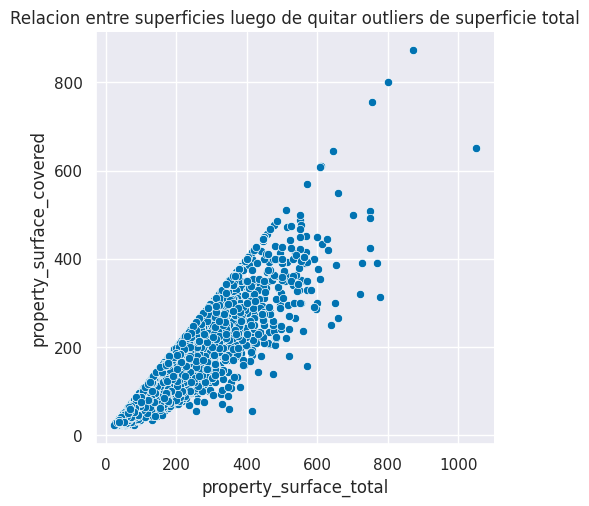

In [576]:
sns.relplot(data=df, x="property_surface_total", y="property_surface_covered", kind="scatter").set(title="Relacion entre superficies luego de quitar outliers de superficie total")

[Text(0.5, 1.0, 'Sup. cubierta tras quitar outliers')]

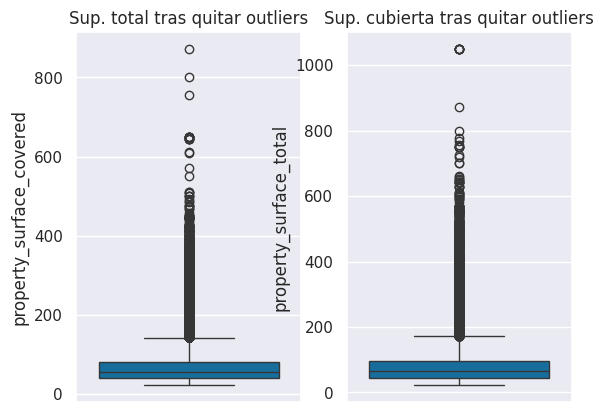

In [577]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df["property_surface_covered"], ax=ax[0]).set(title="Sup. total tras quitar outliers")
sns.boxplot(y=df["property_surface_total"], ax=ax[1]).set(title="Sup. cubierta tras quitar outliers")

Finalmente luego de quitar outliers de forma multivariada y univariada, se llega a la siguiente matriz de correlaciones, en la cual notamos que las superficies tienen una muy alta correlación.

[Text(0.5, 1.0, 'Correlación entre superficies sin outliers')]

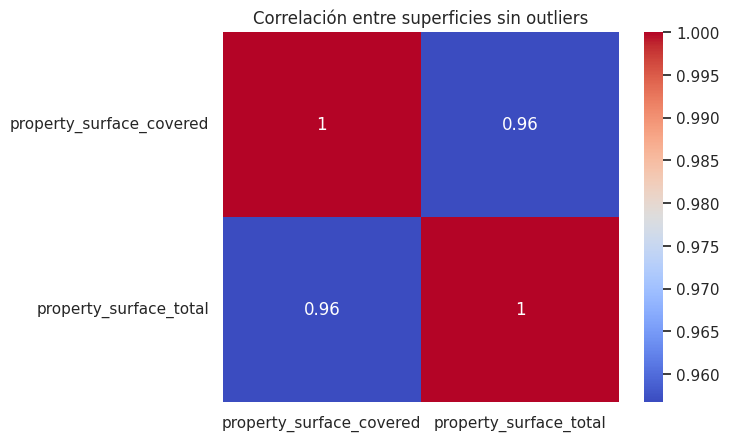

In [543]:
corr = df[["property_surface_covered", "property_surface_total"]].corr()
sns.heatmap(data=corr, annot=True, cmap="coolwarm").set(title="Correlación entre superficies sin outliers")

#### Rooms y Bedrooms

Visualizamos la relación entre ambas variables para encontrar outliers entre ellas.

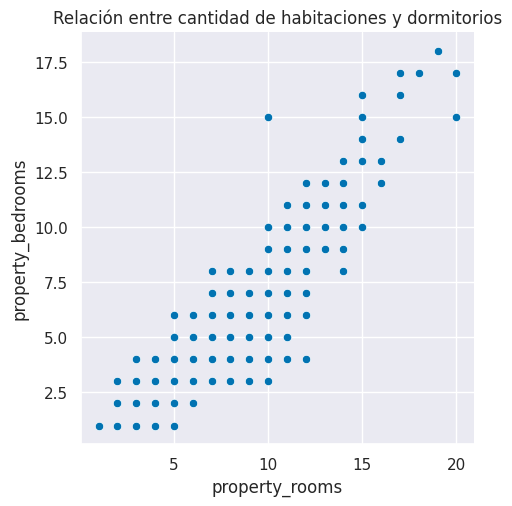

In [544]:
sns.relplot(data=df, x="property_rooms", y="property_bedrooms", kind="scatter").set(title="Relación entre cantidad de habitaciones y dormitorios")

Al ver el gráfico de manera conjunta no notamos outliers drásticos, por lo que procedemos a analizar los outliers de manera univariada.

[Text(0.5, 1.0, 'Cantidad de dormitorios')]

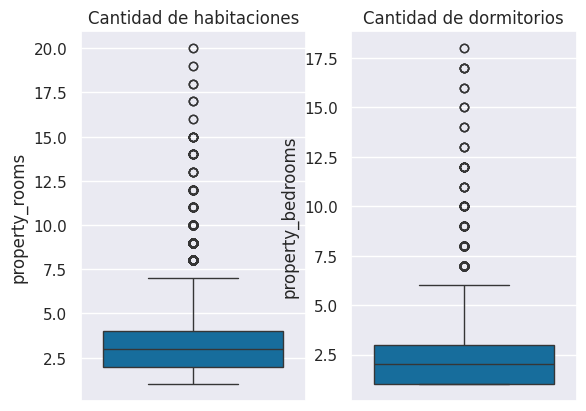

In [546]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df["property_rooms"], ax=ax[0]).set(title="Cantidad de habitaciones")
sns.boxplot(y=df["property_bedrooms"], ax=ax[1]).set(title="Cantidad de dormitorios")

Observamos el resto de valores extremos de `property_bedrooms`.

In [547]:
df[df["property_bedrooms"] > 15][["property_rooms", "property_bedrooms", "property_title"]]

property_rooms  property_bedrooms  \
32758             19.0               18.0   
115403            17.0               17.0   
208593            18.0               17.0   
285222            20.0               17.0   
307211            15.0               16.0   
332857            18.0               17.0   
346602            19.0               18.0   
354668            15.0               16.0   
366101            18.0               17.0   
402448            17.0               16.0   

                                           property_title  
32758           PH 18 HABITACIONES AV ALMTE BROWN LA BOCA  
115403                     PH 17 AMBIENTES - VILLA CRESPO  
208593  Hotel Comercial - Numerosos Ambientes! - Visit...  
285222  VENTA PH EN BARRACAS PB, 1ER PISO Y TERRAZA 80...  
307211  PH  DE16 HABITACIONES IDEAL PARA HOSTEL A RECI...  
332857  Hotel en Venta - 17 habitaciones - Terraza Pro...  
346602   DEPARTAMENTO PH 19 AMBIENTES AV ALMTE BROWN BOCA  
354668  PH  DE16 HABITACIONES IDEAL PARA HOSTEL A RECI...  
366101  Casa sobre Lote Propio - A Refaccionar - Barracas  
402448  IMPONENTE CASA 17 AMB CON TERRAZA VENTA MONSERRAT

Ahora observamos los valores extremos de `property_rooms`.

In [549]:
df[df["property_rooms"] > 15][["property_rooms", "property_bedrooms", "property_title"]]

property_rooms  property_bedrooms  \
32758             19.0               18.0   
115403            17.0               17.0   
153687            17.0               14.0   
192561            16.0               13.0   
208593            18.0               17.0   
225809            16.0               12.0   
285222            20.0               17.0   
332857            18.0               17.0   
346602            19.0               18.0   
366101            18.0               17.0   
402448            17.0               16.0   
438314            20.0               15.0   

                                           property_title  
32758           PH 18 HABITACIONES AV ALMTE BROWN LA BOCA  
115403                     PH 17 AMBIENTES - VILLA CRESPO  
153687                    PH Uso Comercial - Barrio Norte  
192561  Casa con 6 dptos tipo ph en BLOCK, IDEAL PARA ...  
208593  Hotel Comercial - Numerosos Ambientes! - Visit...  
225809  Venta Casa Multifamiliar Local San Telmo Remod...  
285222  VENTA PH EN BARRACAS PB, 1ER PISO Y TERRAZA 80...  
332857  Hotel en Venta - 17 habitaciones - Terraza Pro...  
346602   DEPARTAMENTO PH 19 AMBIENTES AV ALMTE BROWN BOCA  
366101  Casa sobre Lote Propio - A Refaccionar - Barracas  
402448  IMPONENTE CASA 17 AMB CON TERRAZA VENTA MONSERRAT  
438314  Edificio ubicado en el Barrio de Boedo en Vent...

Ambos parecen ser bastante normales por lo que optamos por seguir investigando algunos casos.

También nos interesa saber si hay propiedades con más bedrooms que rooms. Encontramos algunos registros con esta condición, pero como son pocos los dropeamos (fisicamente no tienen sentido).

In [550]:
len(df[df["property_rooms"] < df["property_bedrooms"]])

29

In [551]:
df = df.drop(df[df["property_rooms"] < df["property_bedrooms"]].index)

En este caso optamos por utilizar el z-score modificado como métrica para eliminar outliers.

In [343]:
def z_score_mod(serie):
  median = np.median(serie)
  MAD = np.median(np.absolute(serie - median))
  return (serie - median) * 0.6745 / MAD

Luego de analizar mediante z score modificado descubrimos que solo quedaban 328 registros contados como outliers para `property_rooms` (verificando que su modulo de z-score modificado sea mayor a 3.5), por lo que decidimos dropearlos.

In [552]:
len(df[(z_score_mod(df["property_rooms"]) > 3.5) | (z_score_mod(df["property_bedrooms"]) > 3.5)])

328

In [553]:
df = df.drop(df[(z_score_mod(df["property_rooms"]) > 3.5) | (z_score_mod(df["property_bedrooms"]) > 3.5)].index)

Visualizamos como quedan las distribuciones conjuntas de estas variables y sus outliers. Como las cantidad de cuartos son variables discretas, utilizamos un gráfico de barras en vez de un scatterplot.

[Text(0.5, 1.0, 'Registros por cantidad de cuartos o dormitorios')]

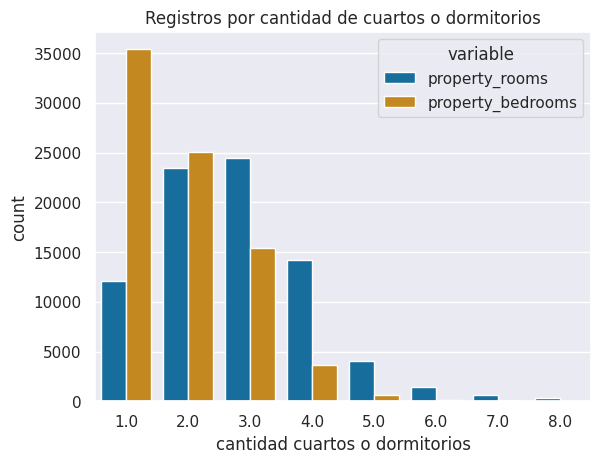

In [554]:
df_long = pd.melt(df, value_vars=["property_rooms", "property_bedrooms"], var_name="variable", value_name="cantidad cuartos o dormitorios")
sns.countplot(data=df_long, x="cantidad cuartos o dormitorios", hue="variable").set(title="Registros por cantidad de cuartos o dormitorios")

Nos llama la atención el que el gráfico distribución nos está diciendo que es una tail-heavy distribution. Las cantidades de propiedades con un número elevado de cuartos y habitaciones son pocas, pero técnicamente no son considerados como outliers con las métricas utilizadas, y tras una inspección manual, vemos que bastantes de estos valores son propiedades que tiene sentido, por ejemplo, muchas de las que tienen 8 cuartos, indican en su descripción que son propiedades espaciosas.

In [557]:
df[df["property_rooms"] == 8][["property_rooms", "property_bedrooms", "property_title"]]

property_rooms  property_bedrooms  \
1040               8.0                6.0   
1108               8.0                6.0   
1349               8.0                6.0   
1363               8.0                6.0   
1800               8.0                7.0   
...                ...                ...   
457064             8.0                7.0   
459306             8.0                4.0   
459706             8.0                5.0   
459755             8.0                5.0   
459764             8.0                4.0   

                                           property_title  
1040              Casa Ideal Dos Familias  - Monte Castro  
1108              Casa Ideal Dos Familias  - Monte Castro  
1349              Casa Ideal Dos Familias  - Monte Castro  
1363              Casa Ideal Dos Familias  - Monte Castro  
1800               Casa 8 Ambientes ubicada en Balvanera   
...                                                   ...  
457064  Casa - Belgrano R - Lote propio - Esquina - Oc...  
459306  Departamento frances en venta en Edificio Estr...  
459706  Excelente departamento con cochera en venta en...  
459755  Departamento de excelente calidad con 5 dormit...  
459764  Departamento frances con 2 cocheras en venta e...  

[294 rows x 3 columns]

Tras el filtro utilizando el z-score, los boxplots nos quedan de la siguiente manera:

[Text(0.5, 1.0, 'Cant. dormitorios tras quitar outliers')]

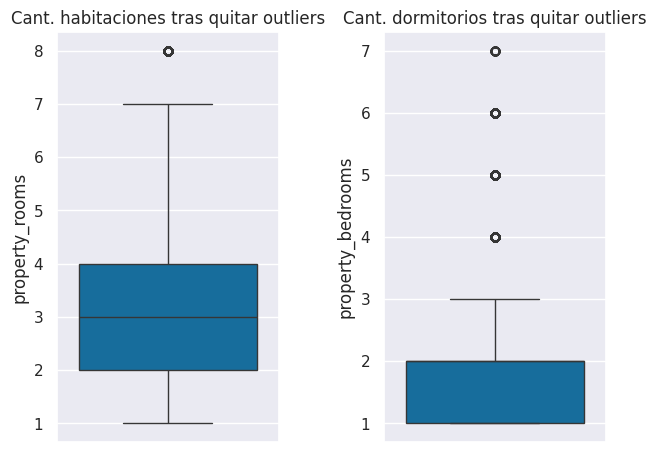

In [558]:
fig, ax = plt.subplots(1, 2);
fig.tight_layout(w_pad=3)

sns.boxplot(y=df["property_rooms"], ax=ax[0]).set(title="Cant. habitaciones tras quitar outliers")
sns.boxplot(y=df["property_bedrooms"], ax=ax[1]).set(title="Cant. dormitorios tras quitar outliers")

#### Precio

Finalmente, también nos interesa conocer si nuestra variable de salida posee outliers. Esto podría afectar significativamente los resultados de las predicciones numéricas. Para eso visualizamos su boxplot.

[Text(0.5, 1.0, 'Outliers de precios')]

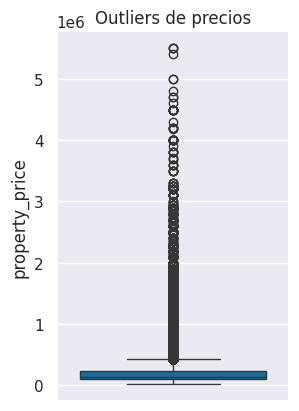

In [349]:
plt.figure().set_figwidth(3)
sns.boxplot(y=df["property_price"]).set(title="Outliers de precios")

A partir del gráfico, podemos ver que hay varios outliers para el precio, por lo que vamos a sacar los más significativos mediante z-score (con un umbral de 3.0).

In [559]:
def z_score(serie):
  media = np.mean(serie)
  std = np.std(serie)
  return (serie - media) / std

Al ser solo 1530 outliers, decidimos dropearlos.

In [560]:
len(df[(z_score(df["property_price"]) > 3) | (z_score(df["property_price"]) < -3)])

1530

In [561]:
df = df.drop(df[(z_score(df["property_price"]) > 3) | (z_score(df["property_price"]) < -3)].index)

Finalmente el boxplot de la variable precio queda conformado de la siguiente forma, donde puede verse una amplia cola de outliers.

[Text(0.5, 1.0, 'Outliers de precios')]

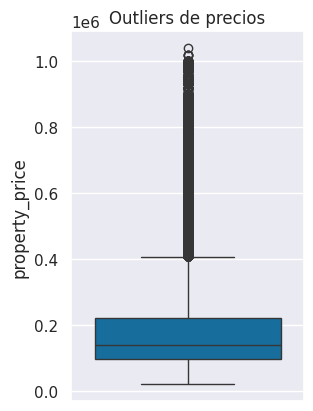

In [562]:
plt.figure().set_figwidth(3)
sns.boxplot(y=df["property_price"]).set(title="Outliers de precios")

#### Relación precio y área

Finalmente analizamos las correlaciones entre las variables luego de lidiar con los outliers y manejar los datos nulos.

[Text(0.5, 1.0, 'Correlación entre variables')]

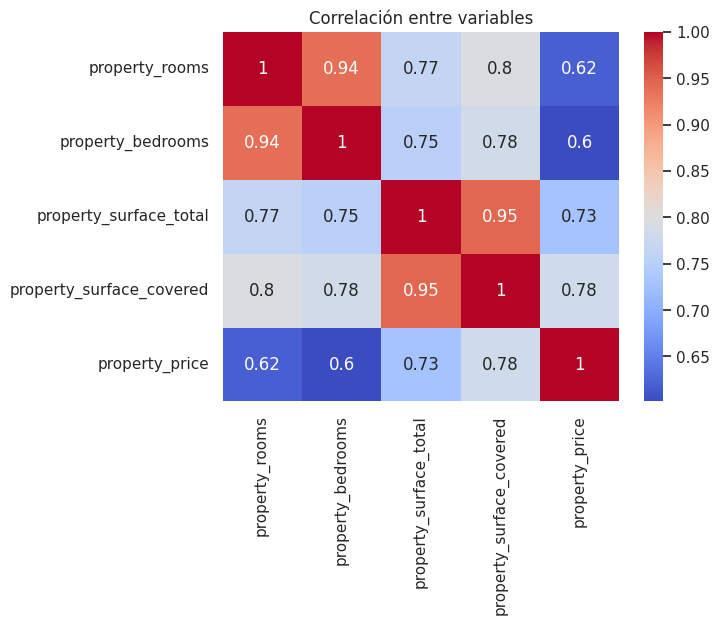

In [563]:
corr = df.select_dtypes(include="number").drop(["latitud", "longitud"], axis="columns").corr()
sns.heatmap(data=corr, annot=True, cmap="coolwarm").set(title="Correlación entre variables")

Notamos que las dos variables que mayor correlación tienen con el precio son las variables que nos aportan información sobre la superficie de la propiedad, particularmente `property_surface_covered`. Podemos visualizar la relación entre estas dos variables para comprender un poco mejor cómo se correlacionan.

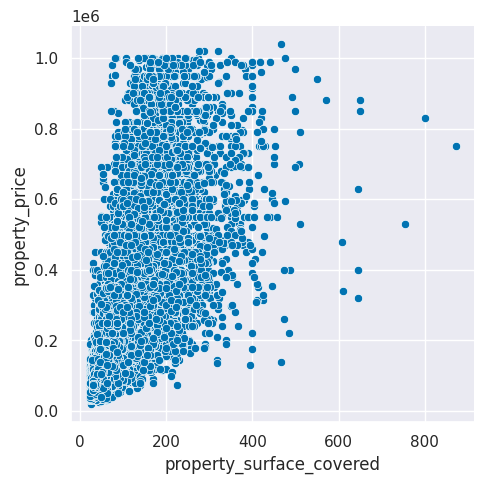

In [564]:
sns.relplot(data=df, x="property_surface_covered", y="property_price", kind="scatter")

Tal como nos indica el coeficiente de correlación de Pearson, ambas variables tienen una relación positiva, que vemos que es más ajustada para valores bajos de superficie cubierta. A valores de superficie más grandes, la variación de precios es mayor, sin embargo no llegamos a considerar ninguna de estas muestras como outliers multivariados, sino solamente como propiedades con altos precios, que puede ser consecuencia de las demás variables más allá de la superficie de la misma.

## Distribuciones originales vs reparadas

A continuación visualizamos las distribuciones de las variables originales (previa a repararlos) vs los atributos reparados.

In [568]:
def visualizar_dist_rooms(variable):
  fig, ax = plt.subplots(1, 2);
  fig.tight_layout(w_pad=3)
  plt.subplots_adjust(top=0.85)

  ax[0].set_title("Antes")
  ax[1].set_title("Después")

  max_rooms_pre = int(df_pre_limpieza[variable].max())
  ax[0].set_xticks(np.arange(0, max_rooms_pre, step=1))
  tick_labels = ['' if i % 10 != 0 else str(i) for i in range(max_rooms_pre)]
  ax[0].set_xticklabels(tick_labels)

  sns.countplot(df_pre_limpieza, x=variable, ax=ax[0])
  sns.countplot(df, x=variable, ax=ax[1])

  fig.suptitle(f"Comparación distribución `{variable}` antes y después de la limpieza")

  plt.show()

In [569]:
def visualizar_dist_continuas(variable):
  fig, ax = plt.subplots(1, 2);
  fig.tight_layout(w_pad=3)
  plt.subplots_adjust(top=0.85)

  ax[0].set_title("Antes")
  ax[1].set_title("Después")

  sns.kdeplot(df_pre_limpieza, x=variable, ax=ax[0])
  sns.kdeplot(df, x=variable, ax=ax[1])

  fig.suptitle(f"Comparación distribución `{variable}` antes y después de la limpieza")

  plt.show()

### Superficie total

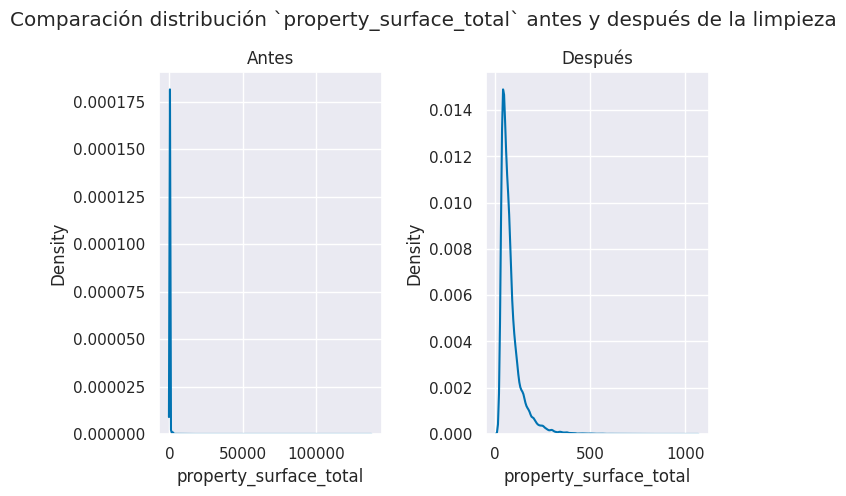

In [570]:
visualizar_dist_continuas("property_surface_total")

Se puede observar que para la variable de superficie se achica el soporte y además se reduce el pico, incrementandose la amplitud de la curva.

### Superficie cubierta

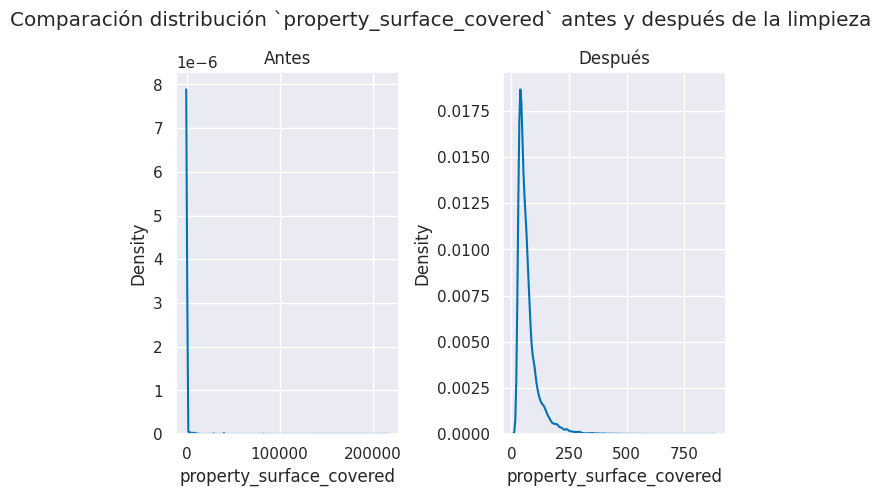

In [571]:
visualizar_dist_continuas("property_surface_covered")

Para esta variable se puede observar que el pico de la densidad decayo enormemente y se redujeron los valores de x. También se observa que los picos más pequeños ya no están presentes.

### Cantidad de habitaciones

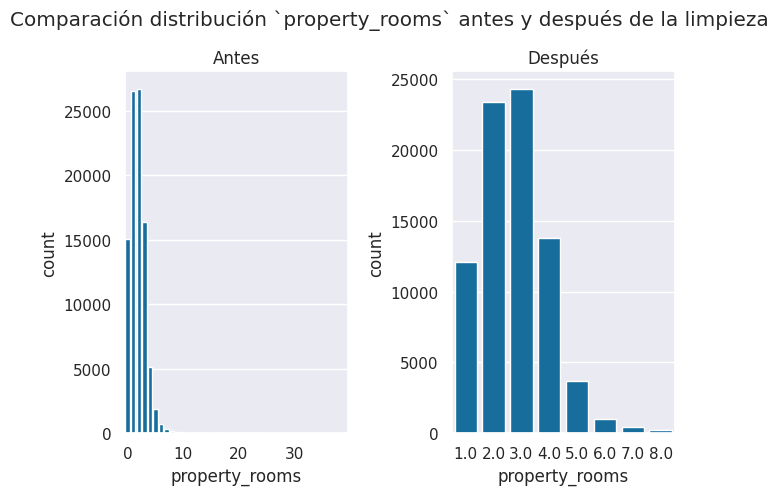

In [572]:
visualizar_dist_rooms("property_rooms")

Esta variable no presenta un cambio muy grande en su distribucion, solo se redujeron los valores que toma y la cantidad de los valores.

### Cantidad de cuartos

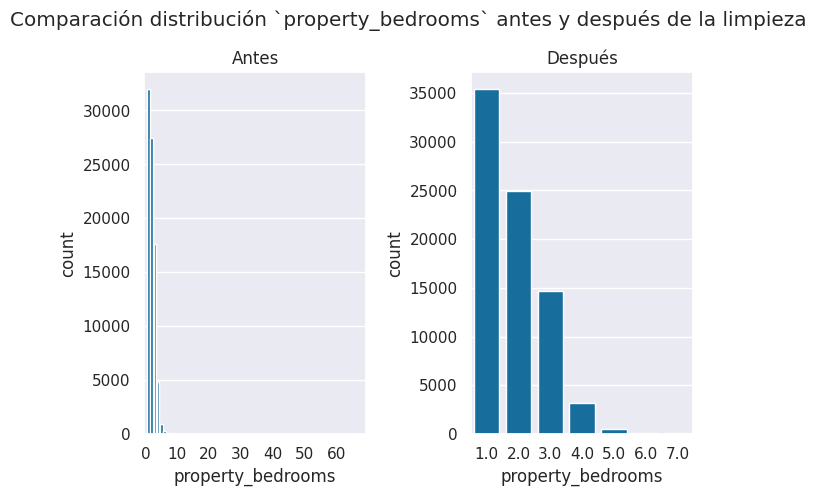

In [573]:
visualizar_dist_rooms("property_bedrooms")

Con esta variable ocurre algo similar a la anterior, se redujeron los valores que toma pero se mantuvo parecida en forma a la original.

### Precio de la propiedad

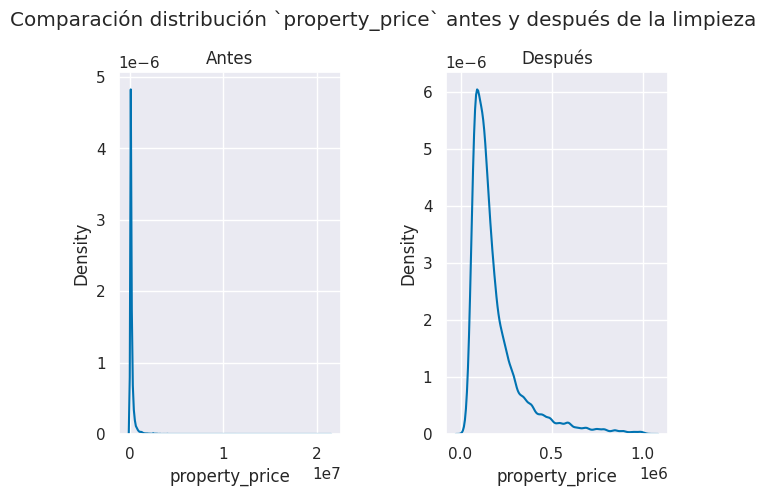

In [574]:
visualizar_dist_continuas("property_price")

Se puede ver que la densidad del precio no varía tanto y mantiene la misma forma que antes de ser reparado. Si puede verse un impacto bastante grande sobre los valores que toma la variable, ya que se reducen significativamente.

# Agrupamiento

Para empezar con la sección de clustering, consideramos oportuno mostrar un gráfico con toda la data antes de ser dividida en clusters.

In [396]:
def scatter_df(df, title):
  fig = plt.figure(figsize=(8,8))
  ax = fig.add_subplot(projection='3d')

  xs = df['property_rooms']
  ys = df['property_surface_total']
  zs = df['property_price']
  ax.scatter(xs, ys, zs, marker='x')

  ax.set_xlabel('Rooms')
  ax.set_ylabel('Total Surface')
  ax.set_zlabel('Price')
  ax.set(title=title)

  plt.show()

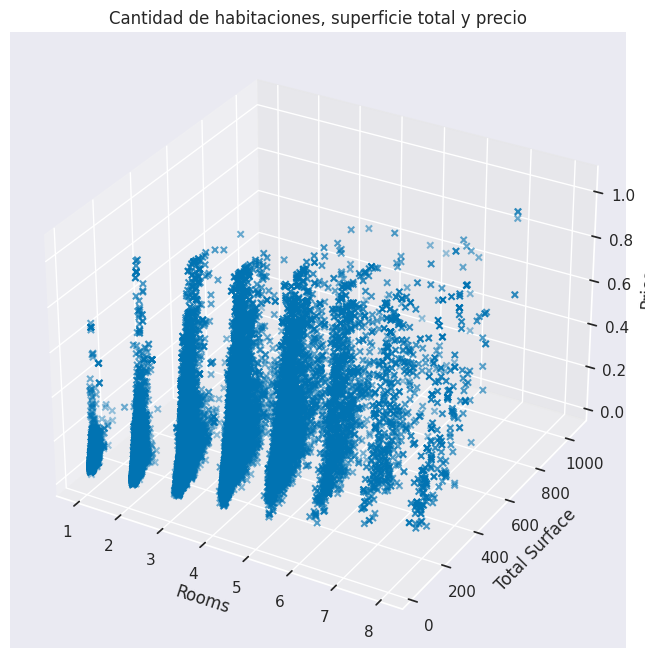

In [397]:
scatter_df(df, "Cantidad de habitaciones, superficie total y precio")

### Tendencia al clustering

KMeans encuentra clusters incluso en datos con una distribución uniforme, con lo cual usarlo sin un previo análisis de la tendencia al clustering del dataset no tendría mucho sentido, porque los grupos no significarían nada. Para hacer este análisis, usamos la estadística de Hopkins.

Necesitamos quedarnos con las columnas numéricas del dataframe para que la función no tenga problemas con los valores no numéricos. También, exceptuamos la latitud y la longitud para quedarnos con variables que puedan ser facilmente comparables.

In [398]:
from typing import Union
from sklearn.neighbors import BallTree

def hopkins(data_frame: Union[np.ndarray, pd.DataFrame]) -> float:
  sampling_size = df.shape[0]

  if type(data_frame) == np.ndarray:
    data_frame = pd.DataFrame(data_frame)

  data_frame_sample = sample_observation_from_dataset(data_frame, sampling_size)

  sample_distances_to_nearest_neighbours = get_distance_sample_to_nearest_neighbours(
    data_frame, data_frame_sample
  )

  uniformly_selected_observations_df = simulate_df_with_same_variation(
    data_frame, sampling_size
  )

  df_distances_to_nearest_neighbours = get_nearest_sample(
    data_frame, uniformly_selected_observations_df
  )

  x = sum(sample_distances_to_nearest_neighbours)
  y = sum(df_distances_to_nearest_neighbours)

  if x + y == 0:
    raise Exception("The denominator of the hopkins statistics is null")

  return x / (x + y)[0]


def get_nearest_sample(df: pd.DataFrame, uniformly_selected_observations: pd.DataFrame):
  tree = BallTree(df, leaf_size=2)
  dist, _ = tree.query(uniformly_selected_observations, k=1)
  uniformly_df_distances_to_nearest_neighbours = dist
  return uniformly_df_distances_to_nearest_neighbours


def simulate_df_with_same_variation(
  df: pd.DataFrame, sampling_size: int
) -> pd.DataFrame:
  max_data_frame = df.max()
  min_data_frame = df.min()
  uniformly_selected_values_0 = np.random.uniform(
    min_data_frame[0], max_data_frame[0], sampling_size
  )
  uniformly_selected_values_1 = np.random.uniform(
    min_data_frame[1], max_data_frame[1], sampling_size
  )
  uniformly_selected_observations = np.column_stack(
    (uniformly_selected_values_0, uniformly_selected_values_1)
  )
  if len(max_data_frame) >= 2:
    for i in range(2, len(max_data_frame)):
      uniformly_selected_values_i = np.random.uniform(
        min_data_frame[i], max_data_frame[i], sampling_size
      )
      to_stack = (uniformly_selected_observations, uniformly_selected_values_i)
      uniformly_selected_observations = np.column_stack(to_stack)
  uniformly_selected_observations_df = pd.DataFrame(uniformly_selected_observations)
  return uniformly_selected_observations_df


def get_distance_sample_to_nearest_neighbours(df: pd.DataFrame, data_frame_sample):
  tree = BallTree(df, leaf_size=2)
  dist, _ = tree.query(data_frame_sample, k=2)
  data_frame_sample_distances_to_nearest_neighbours = dist[:, 1]
  return data_frame_sample_distances_to_nearest_neighbours


def sample_observation_from_dataset(df, sampling_size: int):
  if sampling_size > df.shape[0]:
    raise Exception("The number of sample of sample is bigger than the shape of D")
  data_frame_sample = df.sample(n=sampling_size)
  return data_frame_sample

In [399]:
hopkins(df[['property_rooms', 'property_surface_total', 'property_price']])

0.004772364877137104

En la implementación de la librería `pyclustertend` se indica que, usando el método `hopkins`, un valor más cercano a 0 implica una mayor tendencia a la clusterización. En nuestro caso, se puede ver una fuerte tendencia al clustering, con lo cual podemos proceder a usar KMeans para encontrar clusters en nuestro dataset.

### Cantidad óptima de grupos

Para evaluar la cantidad óptima de grupos que se deben formar, aplicamos KMeans varias veces y calculamos el coeficiente de Silhouette promedio de toda la muestra en cada ocasión.


In [400]:
from sklearn.metrics import silhouette_score
from sklearn.cluster import KMeans

lista_distintos_k = range(2, 10)
data = df[['property_rooms', 'property_surface_total', 'property_price']]

scores = {}
best_n_clusters = lista_distintos_k[0]

for n_clusters in lista_distintos_k:
  clusterer = KMeans(n_clusters=n_clusters, n_init='auto')
  preds = clusterer.fit_predict(data)
  score = silhouette_score(data, preds)
  scores[n_clusters] = score

  if score > scores[best_n_clusters]:
    best_n_clusters = n_clusters

  print("Para n_clusters=" + str(n_clusters) + ", el score de silhouette es " + str(score))

print(f"Cantidad de clusters más óptima: {best_n_clusters}")

Para n_clusters=2, el score de silhouette es 0.736745925638332
Para n_clusters=3, el score de silhouette es 0.6494794013865816
Para n_clusters=4, el score de silhouette es 0.604783655216784
Para n_clusters=5, el score de silhouette es 0.5649239627330448
Para n_clusters=6, el score de silhouette es 0.5566715172283128
Para n_clusters=7, el score de silhouette es 0.5555255831002663
Para n_clusters=8, el score de silhouette es 0.5582760702208948
Para n_clusters=9, el score de silhouette es 0.5564497153348089
Cantidad de clusters más óptima: 2


Nos quedamos con dos grupos, que es la cantidad cuyo coeficiente de Silhouette es el más cercano a 1. Pareciera que a medida que intentamos con más grupos, el coeficiente cae.

Entonces, aplicamos KMeans para que encuentre dos clusters en nuestro dataframe, y lo graficamos.

In [401]:
COLORES_GRUPOS = 'plasma'

def kmean_scatter_plot(df=None, clusters=2, title=None, elev=None, axim=None, roll=None):
  labels = KMeans(clusters, random_state=0, n_init='auto').fit_predict(df[['property_rooms', 'property_surface_total', 'property_price']])

  fig = plt.figure(figsize=(8,10))

  ax = fig.add_subplot(projection='3d')
  ax.view_init(elev=elev, azim=axim, roll=roll)

  xs = df['property_rooms']
  ys = df['property_surface_total']
  zs = df['property_price']
  ax.scatter(xs, ys, zs, marker='.', c=labels, cmap=COLORES_GRUPOS)

  ax.set_xlabel('Rooms')
  ax.set_ylabel('Total Surface')
  ax.set_zlabel('Price')
  ax.set(title=title)

  plt.show()

  return labels

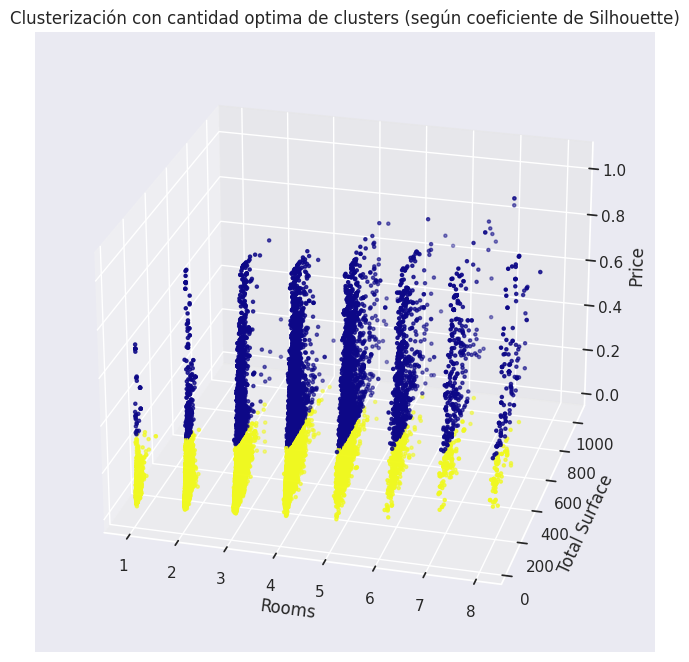

In [402]:
clusters = kmean_scatter_plot(df, best_n_clusters, "Clusterización con cantidad optima de clusters (según coeficiente de Silhouette)", elev=25, axim=-75, roll=0)
clustered_df = df.assign(cluster=clusters)

Pareciera que la variable más significativa fue el precio. Viendo el scatterplot desde un lado, se ve una clara división a partir de ciertos precios, como si hubiese un plano horizontal que corta los datos.

In [403]:
first_cluster = clustered_df[clustered_df['cluster'] == 0]
second_cluster = clustered_df[clustered_df['cluster'] == 1]

In [404]:
first_cluster.describe().apply(lambda s: s.apply('{0:.5f}'.format))

latitud     longitud property_rooms property_bedrooms  \
count  10456.00000  10456.00000    10456.00000       10456.00000   
mean     -35.88350    -57.13023        4.20868           2.97934   
std        5.40979      5.41299        1.13476           0.89397   
min      -58.52604    -58.52993        1.00000           1.00000   
25%      -34.60323    -58.45213        4.00000           2.00000   
50%      -34.58649    -58.42814        4.00000           3.00000   
75%      -34.56942    -58.39430        5.00000           3.00000   
max      -34.53609    -34.54348        8.00000           7.00000   

      property_surface_total property_surface_covered property_price  \
count            10456.00000              10456.00000    10456.00000   
mean               174.01182                149.48747   496039.00976   
std                 87.49718                 67.26092   164625.56816   
min                 37.00000                 31.00000   318900.00000   
25%                119.00000                105.00000   369000.00000   
50%                151.00000                135.00000   445000.00000   
75%                201.00000                177.00000   585000.00000   
max               1050.00000                872.00000  1040000.00000   

           cluster  
count  10456.00000  
mean       0.00000  
std        0.00000  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        0.00000  
max        0.00000

In [405]:
second_cluster.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  68444.000000  68444.000000    68444.000000       68444.000000   
mean     -35.344048    -57.693867        2.514494           1.675633   
std        4.152307      4.155818        1.057337           0.813512   
min      -58.526039    -58.530391        1.000000           1.000000   
25%      -34.619303    -58.467463        2.000000           1.000000   
50%      -34.598574    -58.439407        2.000000           1.000000   
75%      -34.579163    -58.409042        3.000000           2.000000   
max      -34.535964    -34.543481        8.000000           7.000000   

       property_surface_total  property_surface_covered  property_price  \
count            68444.000000              68444.000000    68444.000000   
mean                67.670963                 58.096248   141730.381743   
std                 37.604986                 28.410846    63587.994337   
min                 23.000000                 23.000000    20000.000000   
25%                 43.000000                 39.000000    90000.000000   
50%                 58.545514                 51.000000   129000.000000   
75%                 80.000000                 70.000000   179900.000000   
max                539.000000                485.000000   318600.000000   

       cluster  
count  68444.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

Viendo estos datos de ambos clusters podemos empezar a obtener información sobre los mismos. Lo primero que se destaca es que el cluster 0 tiene mucha menos cantidad de integrantes que el cluster 1: 10456 a 68444, respectivamente. También, es notable que los precios del cluster 0 son mayores a los del 1, como se evidencia cuando se mira los valores máximos y los promedios de ambos. Esta tendencia parece mantenerse en los promedios de las demás columnas.

En base a los valores máximos y mínimos del `property_price`, podemos darnos cuenta de que el cluster 0 es el que está representado en azul en el gráfico, y el otro es el amarillo. Los valores máximos y mínimos de las demás columas son muy similares, pero en el precio la diferencia es muy notoria. El precio máximo del cluster 1 se encuentra por debajo del precio mínimo del cluster 0, con lo cual la división que encontró KMeans se vio muy influenciada por esa columna.

Con toda esta información, concluimos que el cluster 0 está conformado por las propiedades más costosas y generalmente más espaciosas, que resultan también ser las menos numerosas; mientras que el cluster 1 está formado por las propiedades menos costosas y más pequeñas, que resultan conformar la mayor parte del dataset.

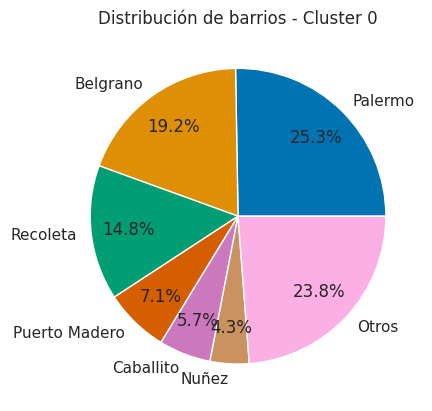

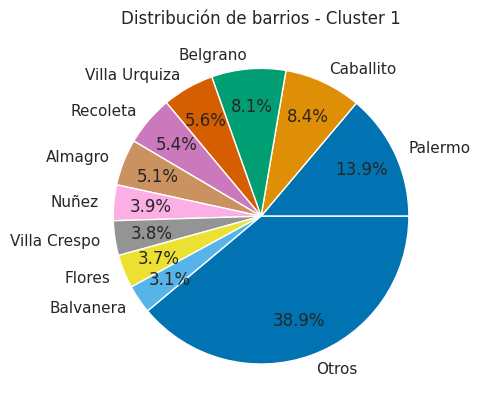

In [406]:
plt.figure(0)
distribucion_barrios(first_cluster, 6, "Distribución de barrios - Cluster 0")
plt.figure(1)
distribucion_barrios(second_cluster, 10, "Distribución de barrios - Cluster 1")
plt.show()

Un descubrimiento interesante es que la distribución de barrios es notoriamente distinta entre los grupos. El cluster 0 se encuentra conformado principalmente por propiedades ubicadas en los barrios de Palermo, Belgrano, Recoleta y Puerto Madero, que representan un 66,4% del total. Sin embargo, para el cluster 1, Puerto Madero y Recoleta se ven desplazados por Caballito y Villa Urquiza, mientras que los demás ven sus porcentajes drásticamente reducidos.

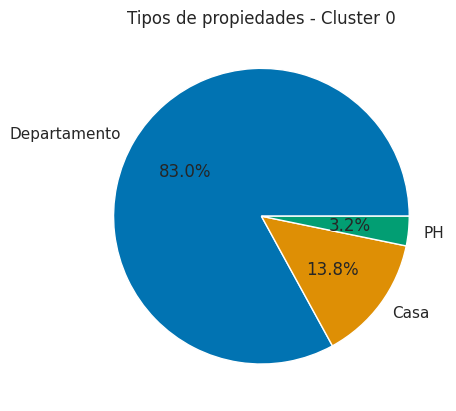

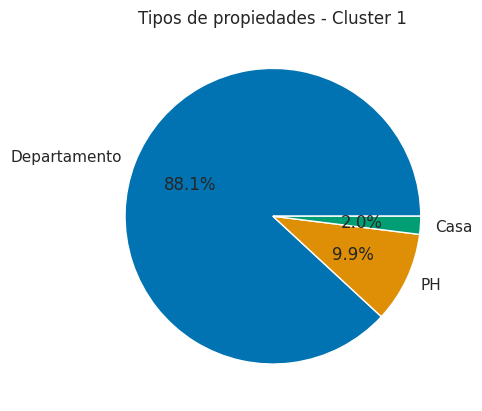

In [407]:
plt.figure(0)
distribucion_property_type(first_cluster, "Tipos de propiedades - Cluster 0")
plt.figure(1)
distribucion_property_type(second_cluster, "Tipos de propiedades - Cluster 1")
plt.show()

Respecto de los tipos de propiedades, en ambos clusters hay una notoria mayoría de departamentos. Resalta que en el cluster 0, hay una cantidad de casas y PHs similares, pero en el otro hay una mucho mayor presencia de PHs.

### Datos sobre mapa de CABA

Si graficaramos estos datos sobre un mapa, por como quedaron formados los clusters, podríamos ver como se reparten los precios de las viviendas en las diferentes zonas de CABA.

Para poder hacer esto, primero hay que verificar que los datos de latitudes y longitudes sean correctos. Para eso, hacemos un boxplot de cada uno.

[Text(0.5, 1.0, 'Longitud')]

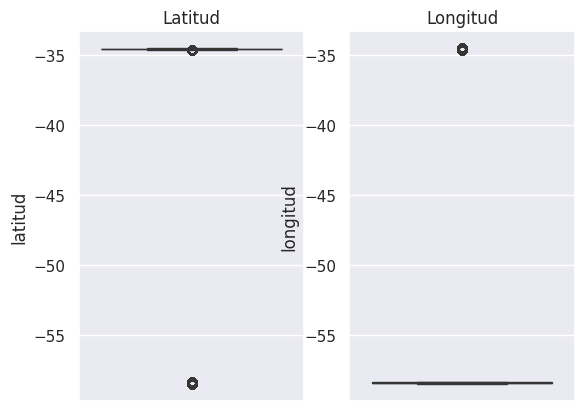

In [408]:
fig, ax = plt.subplots(1, 2);

sns.boxplot(y=df["latitud"], ax=ax[0]).set(title="Latitud")
sns.boxplot(y=df["longitud"], ax=ax[1]).set(title="Longitud")

Ambos boxplots muestran grupos de outliers muy definidos. Lo curioso es que los outliers de uno parecen ubicarse en los valores donde se encuentra el promedio del otro. Esto pareciera indicar que la latitud y la longitud en los outliers están invertidas. Con lo cual, procedemos a acomodar esos datos.

[Text(0.5, 1.0, 'Longitud reparada')]

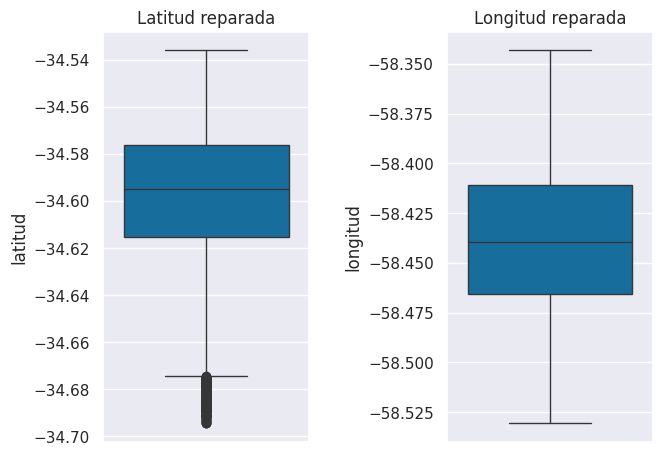

In [409]:
latitudes_errones = df['latitud'] < -50

longitudes = df[latitudes_errones]['longitud']
df.loc[latitudes_errones, 'longitud'] = df[df['latitud'] < -50]['latitud']
df.loc[latitudes_errones, 'latitud'] = longitudes

longitudes_erroneas = df['longitud'] > -55

latitudes = df[longitudes_erroneas]['latitud']
df.loc[longitudes_erroneas, 'latitud'] = df[df['latitud'] < -50]['longitud']
df.loc[longitudes_erroneas, 'longitud'] = latitudes

fig, ax = plt.subplots(1, 2)
fig.tight_layout(w_pad=5)

sns.boxplot(y=df["latitud"], ax=ax[0]).set(title="Latitud reparada")
sns.boxplot(y=df["longitud"], ax=ax[1]).set(title="Longitud reparada")

Volvemos a mostrar los boxplots y vemos que ahora se ven mejor, con lo cual podemos graficar los anuncios sobre un mapa de CABA.

In [410]:
COLORES_GRUPOS = "plasma"
def show_map(df, column_to_plot, title='', show_legend=False):
  crs = 'EPSG:4326'
  geometry = [Point(xy) for xy in zip(df['longitud'], df['latitud'])]
  geo_df = gpd.GeoDataFrame(df,
                            crs = crs,
                            geometry = geometry)

  fig, ax = plt.subplots(figsize = (10,10))
  caba_map.plot(ax=ax, color='lightgrey')

  if show_legend:
    geo_ax = geo_df.plot(column=column_to_plot, ax=ax, alpha=.05, cmap=COLORES_GRUPOS, legend=True, categorical=True)
    legend = geo_ax.get_legend()
    for handle in legend.legend_handles:
      handle.set_alpha(1)
  else:
    geo_df.plot(column=column_to_plot, ax=ax, alpha=.05, cmap=COLORES_GRUPOS)

  ax.set_title(title)

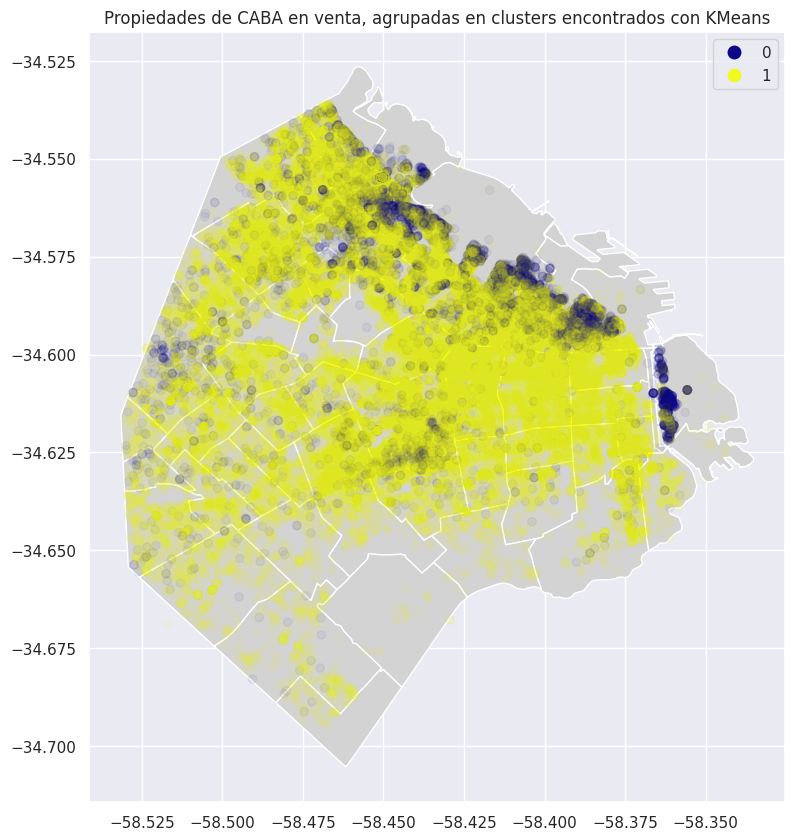

In [446]:
clusters = KMeans(2, random_state=0, n_init='auto').fit_predict(df[['property_rooms', 'property_surface_total', 'property_price']])
clustered_df = df.assign(cluster=clusters)

show_map(
  clustered_df,
  column_to_plot='cluster',
  title='Propiedades de CABA en venta, agrupadas en clusters encontrados con KMeans',
  show_legend=True
)

En el mapa, se ve que el grupo de anuncios de propiedades con menores precios
está repartido por toda la ciudad, mientras que el otro se encuentra bastante concentrado en 5 barrios: Puerto Madero, Retiro, Recoleta, Palermo y Belgrano. Esto ya lo habíamos adelantado cuando se realizó un análisis de los barrios de cada cluster.

Otro dato no menor es que hay grandes zonas de CABA con una muy baja densidad de anuncios, como en Villa Ligano, Villa Soldati y Villa Riachuelo, y una pequeña zona en Agronomía, La Paternal y Chacarita.

### Con tres grupos

Si aplicamos KMeans con 3 clusters, esa mayor cantidad de clusters nos va a permitir, una vez graficados los anuncios sobre el mapa, hacer observaciones un poco más precisas.

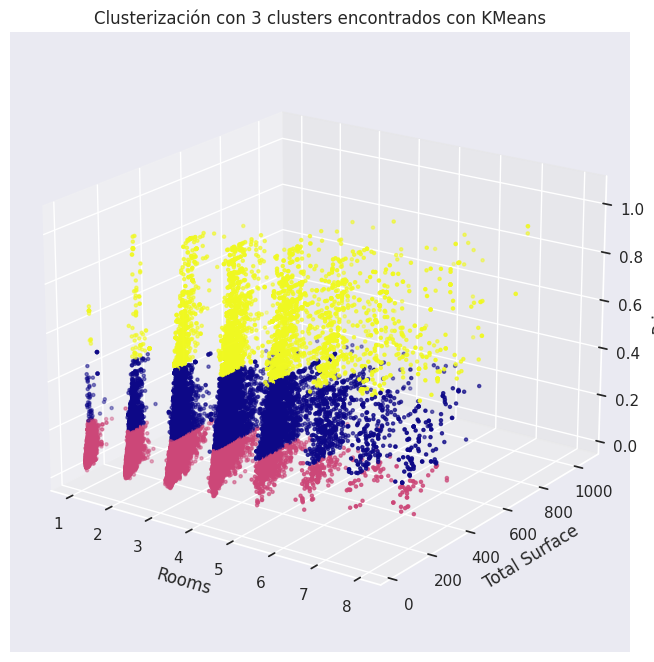

In [412]:
clusters = kmean_scatter_plot(df, 3, "Clusterización con 3 clusters encontrados con KMeans", elev=20, axim=-55, roll=0)
clustered_df = df.assign(cluster=clusters)

In [413]:
first_cluster = clustered_df[clustered_df['cluster'] == 0]
second_cluster = clustered_df[clustered_df['cluster'] == 1]
third_cluster = clustered_df[clustered_df['cluster'] == 2]

In [414]:
first_cluster.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  15977.000000  15977.000000    15977.000000       15977.000000   
mean     -34.588422    -58.437074        3.798648           2.689491   
std        0.024773      0.036428        1.007708           0.872670   
min      -34.692474    -58.530139        1.000000           1.000000   
25%      -34.603620    -58.461171        3.000000           2.000000   
50%      -34.587199    -58.438334        4.000000           3.000000   
75%      -34.569494    -58.409667        4.000000           3.000000   
max      -34.536092    -58.344378        8.000000           7.000000   

       property_surface_total  property_surface_covered  property_price  \
count            15977.000000              15977.000000    15977.000000   
mean               131.097641                110.527100   318307.495212   
std                 63.272120                 47.602398    76351.735995   
min                 35.000000                 31.000000   220772.000000   
25%                 90.000000                 79.000000   251100.000000   
50%                115.000000                100.000000   298000.000000   
75%                150.000000                130.000000   370000.000000   
max                659.000000                644.000000   500000.000000   

       cluster  
count  15977.0  
mean       0.0  
std        0.0  
min        0.0  
25%        0.0  
50%        0.0  
75%        0.0  
max        0.0

In [415]:
second_cluster.describe()

latitud      longitud  property_rooms  property_bedrooms  \
count  59222.000000  59222.000000    59222.000000       59222.000000   
mean     -34.598110    -58.441072        2.343960           1.541268   
std        0.026569      0.037383        0.970874           0.722955   
min      -34.694451    -58.530391        1.000000           1.000000   
25%      -34.617640    -58.468578        2.000000           1.000000   
50%      -34.598830    -58.440739        2.000000           1.000000   
75%      -34.578936    -58.412655        3.000000           2.000000   
max      -34.535964    -58.343239        8.000000           7.000000   

       property_surface_total  property_surface_covered  property_price  \
count            59222.000000              59222.000000    59222.000000   
mean                60.471763                 52.315856   122890.982135   
std                 29.281686                 22.004836    43975.516039   
min                 23.000000                 23.000000    20000.000000   
25%                 41.000000                 37.000000    87000.000000   
50%                 54.000000                 47.000000   119000.000000   
75%                 72.000000                 62.000000   155000.000000   
max                530.000000                485.000000   220590.000000   

       cluster  
count  59222.0  
mean       1.0  
std        0.0  
min        1.0  
25%        1.0  
50%        1.0  
75%        1.0  
max        1.0

In [416]:
third_cluster.describe().apply(lambda s: s.apply('{0:.5f}'.format))

latitud    longitud property_rooms property_bedrooms  \
count  3701.00000  3701.00000     3701.00000        3701.00000   
mean    -34.58149   -58.42145        4.48608           3.13213   
std       0.01980     0.03568        1.21817           0.89449   
min     -34.68869   -58.52798        1.00000           1.00000   
25%     -34.59219   -58.44711        4.00000           3.00000   
50%     -34.57960   -58.42224        4.00000           3.00000   
75%     -34.56660   -58.39449        5.00000           4.00000   
max     -34.53747   -58.35569        8.00000           7.00000   

      property_surface_total property_surface_covered property_price  \
count             3701.00000               3701.00000     3701.00000   
mean               209.49291                182.44785   681904.76601   
std                102.07350                 76.88238   133498.88192   
min                 55.00000                 49.00000   500600.00000   
25%                147.00000                130.00000   570000.00000   
50%                187.00000                167.00000   650000.00000   
75%                240.00000                215.00000   780000.00000   
max               1050.00000                872.00000  1040000.00000   

          cluster  
count  3701.00000  
mean      2.00000  
std       0.00000  
min       2.00000  
25%       2.00000  
50%       2.00000  
75%       2.00000  
max       2.00000

Con tres grupos, parecería suceder el mismo fenómeno anterior: los grupos se forman, principalmente, en función del precio de los anuncios.

- Cluster 0: Precios de 220.772 a 500.000
- Cluster 1: Precios de 20.000 a 220.590
- Cluster 2: Precios de 500.600 a 1.040.000

Sin embargo, es destacable que el grupo más numeroso es el de precios bajos, que agrupa 59222 propiedades. Luego le seguirían el cluster de precios medios, con 15977 propiedades; y el más pequeño es el de precios altos, con 3701 propiedades.

Respecto de las demás columnas, los promedios mantienen la misma relación que cuando se usaron dos clusters. A mayor precio, más espaciosas son las propiedades en promedio.

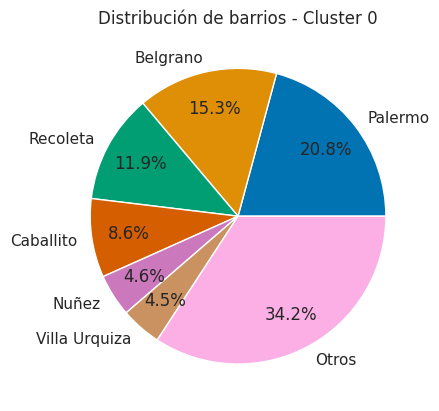

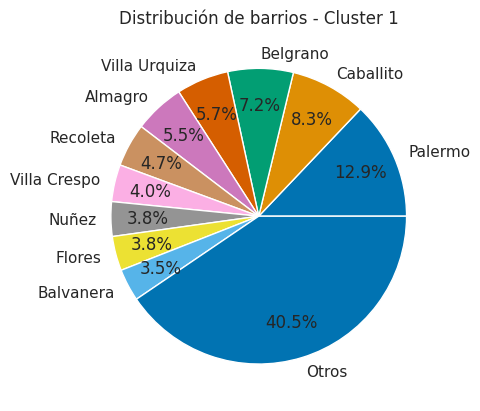

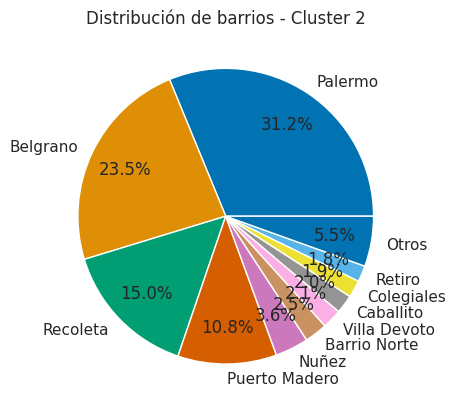

In [417]:
plt.figure(0)
distribucion_barrios(first_cluster, 6, "Distribución de barrios - Cluster 0")
plt.figure(1)
distribucion_barrios(second_cluster, 10, "Distribución de barrios - Cluster 1")
plt.figure(2)
distribucion_barrios(third_cluster, 10, "Distribución de barrios - Cluster 2")
plt.show()

Respecto de la distribución de los barrios, en el cluster más pequeño hay una mucho mayor presencia de los barrios de Palermo, Recoleta, Puerto Madero y Belgrano que en los otros dos, representando un 80.5% de todos los anuncios. Se puede ver como en los demás clusters disminuye la presencia de los tres entre menores son los precios de las propiedades agrupadas.

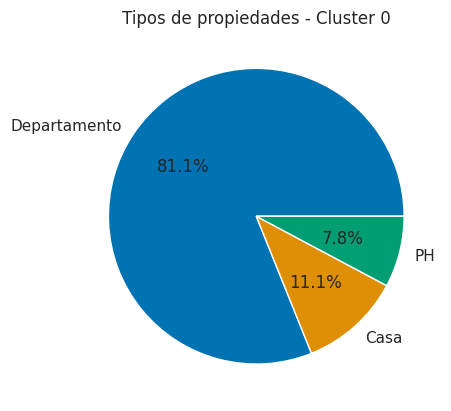

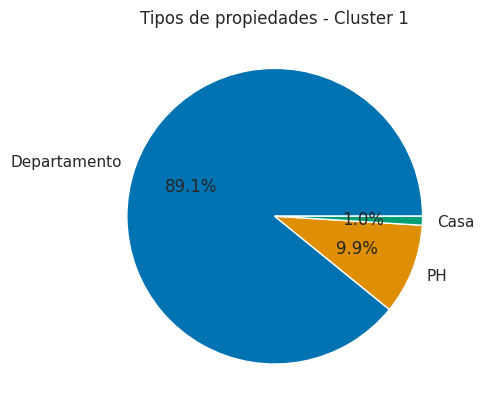

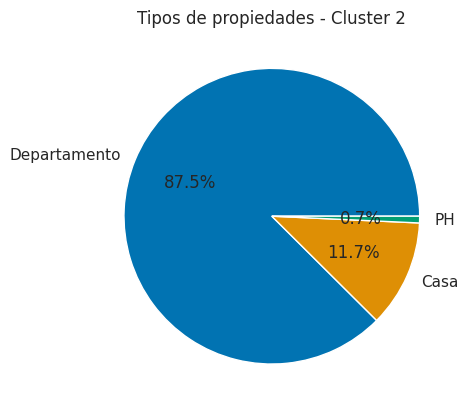

In [418]:
plt.figure(0)
distribucion_property_type(first_cluster, "Tipos de propiedades - Cluster 0")
plt.figure(1)
distribucion_property_type(second_cluster, "Tipos de propiedades - Cluster 1")
plt.figure(2)
distribucion_property_type(third_cluster, "Tipos de propiedades - Cluster 2")
plt.show()

La distribución de tipos de propiedades es muy similar a la vista en los dos clusters que usamos para agrupar anteriormente. Sin embargo, en el cluster 2 la presencia de PHs es muy reducida.

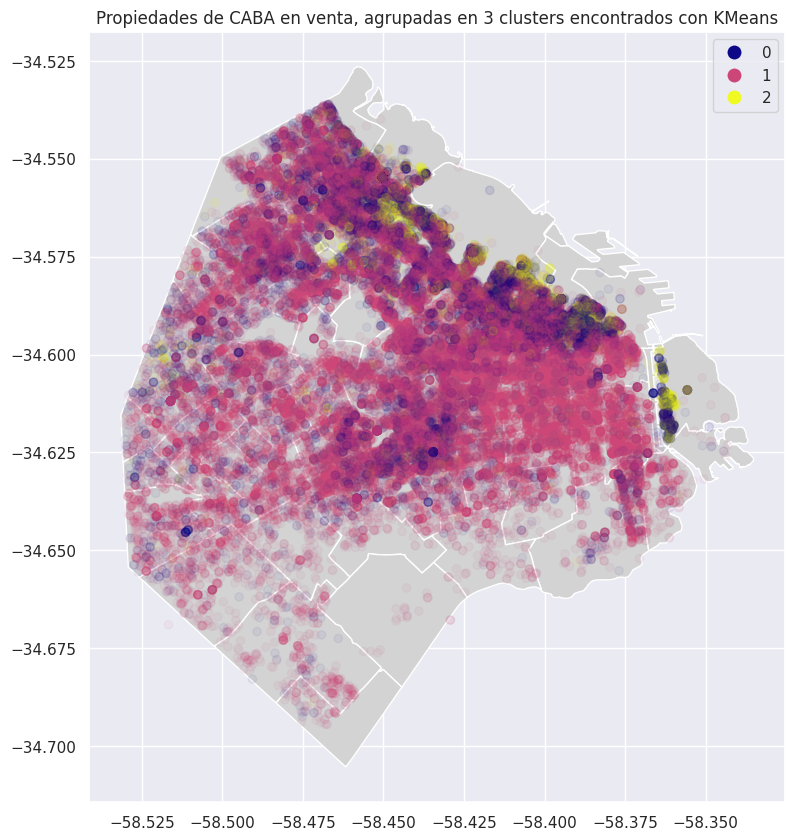

In [419]:
show_map(
  clustered_df,
  column_to_plot='cluster',
  title='Propiedades de CABA en venta, agrupadas en 3 clusters encontrados con KMeans',
  show_legend=True
)

Como ahora disponemos de tres grupos de precios, podemos distinguir zonas en donde los anuncios tienen un precio intermedio, ni muy alto ni muy bajo. Entre ellas, se destacan Caballito y Almagro.

También, se puede ver que en las zonas con los precios más altos, hay mayor cantidad de anuncios con precios intermedios que en el resto de los barrios.

# Clasificación

## Construcción del target

Definimos las categorías en las que vamos a clasificar los precios.

In [420]:
TIPOS_PRECIO = ['bajo', 'medio', 'alto']

Creamos la variable `precio_m2`, que guarda el precio por metro cuadrado de las propiedades.

In [421]:
df['precio_m2'] = df['property_price'] / df['property_surface_total']

Text(0.5, 12.44444444444443, 'Precio por $m^2$')

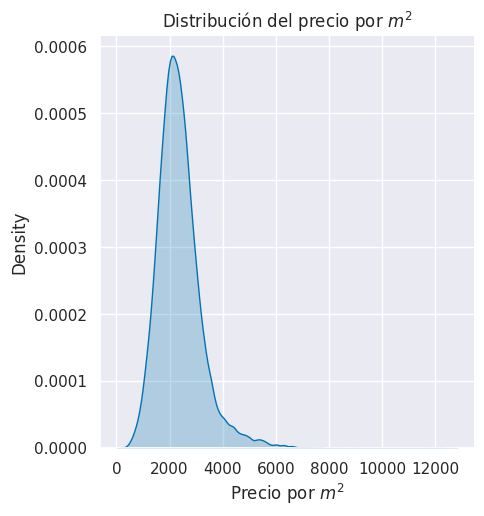

In [422]:
sns.displot(data=df['precio_m2'], kind='kde', fill=True).set(title="Distribución del precio por $m^2$")
plt.xlabel('Precio por $m^2$')

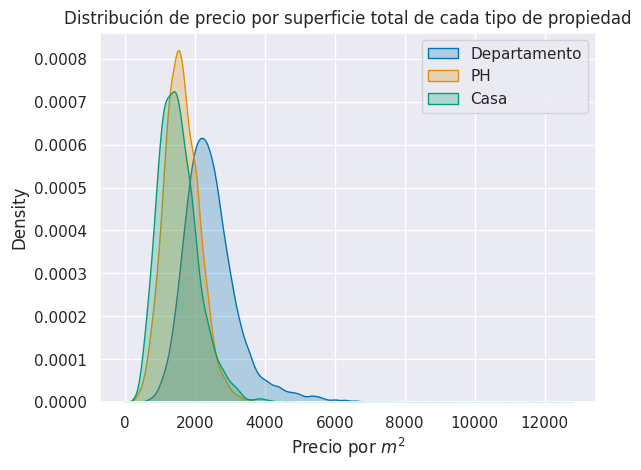

In [423]:
sns.kdeplot(data=df[df['property_type'] == 'Departamento']['precio_m2'], fill=True, label="Departamento").set(title="Distribución de precio por superficie total de cada tipo de propiedad")
sns.kdeplot(data=df[df['property_type'] == 'PH']['precio_m2'], fill=True, label='PH')
sns.kdeplot(data=df[df['property_type'] == 'Casa']['precio_m2'], fill=True, label='Casa')

plt.xlabel('Precio por $m^2$')
plt.legend()

Para asignar una categoría de precios a cada propiedad, primero tenemos que definir cómo vamos a establecer los límites entre las mismas. Para esto probamos las tres estrategias sugeridas:
1. Dividir la variable pxm2 en 3 intervalos con igual cantidad de observaciones.
2. Dividir la variable pxm2 en 3 intervalos, el primero con el 25% de las observaciones,
el siguiente con el 50% y el último con el 25% de las observaciones restantes.
3. Trabajar la variable pxm2 relativa a cada tipo de propiedad y luego dividirla como en
el punto anterior.

In [424]:
precios_bins_iguales = pd.qcut(df['precio_m2'], q=3, labels=TIPOS_PRECIO)
precios_bins_q1_y_q3 = pd.qcut(df['precio_m2'], q=[0, 0.25, 0.75, 1], labels=TIPOS_PRECIO)

In [425]:
df_departamentos = df[df['property_type'] == 'Departamento']
df_phs = df[df['property_type'] == 'PH']
df_casas = df[df['property_type'] == 'Casa']

precios_bins_departamentos = pd.qcut(df_departamentos['precio_m2'], q=[0, 0.25, 0.75, 1], labels=TIPOS_PRECIO)
precios_bins_phs = pd.qcut(df_phs['precio_m2'], q=[0, 0.25, 0.75, 1], labels=TIPOS_PRECIO)
precios_bins_casas = pd.qcut(df_casas['precio_m2'], q=[0, 0.25, 0.75, 1], labels=TIPOS_PRECIO)

In [426]:
colors = sns.color_palette("colorblind")

Primero observamos la distribución de los tipos de precio si hacemos la división homogénea.

In [427]:
precios_bins_iguales.value_counts()

precio_m2
bajo     26333
alto     26293
medio    26274
Name: count, dtype: int64

[Text(0.5, 1.0, 'Distribución de los tipos de precio con cantidades homogéneas de muestras')]

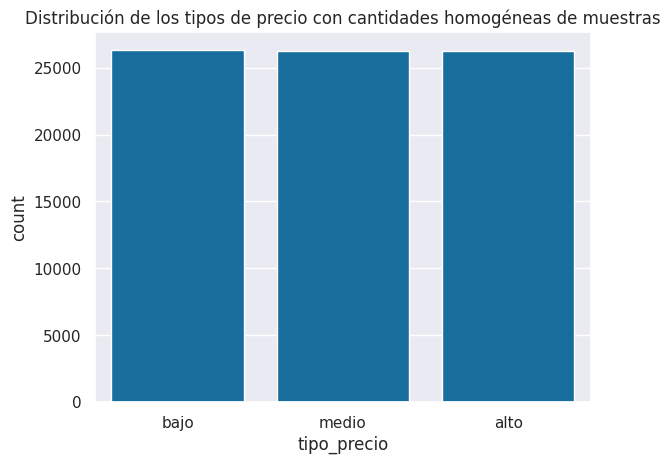

In [428]:
bins_iguales = pd.DataFrame({ "property_type": df.loc[precios_bins_iguales.index, "property_type"], "tipo_precio": precios_bins_iguales })
sns.countplot(data=bins_iguales, x="tipo_precio").set(title="Distribución de los tipos de precio con cantidades homogéneas de muestras")

Si quisieramos ver cómo se reparten los diferentes tipos de propiedades en estos rangos de precio, podemos visualizar el siguiente gráfico:

Text(0.5, 1.0, 'Distribución de tipos de precios según el tipo de propiedad')

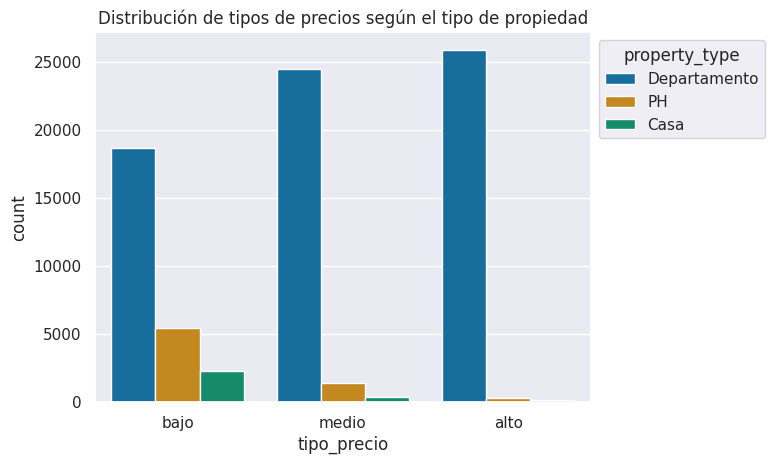

In [429]:
ax = sns.countplot(data=bins_iguales, x="tipo_precio", hue="property_type")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Distribución de tipos de precios según el tipo de propiedad")

Esta visualización nos permite concluir que la mayoría de las casas y PHs terminan siendo ubicadas en el rango de precio bajo, mientras que la mayoría de los departamentos son considerados de precio medio o alto.

Luego observamos las distribuciones si establecemos los límites utilizando el el rango intercuartil.

In [430]:
precios_bins_q1_y_q3.value_counts()

precio_m2
medio    39635
bajo     19729
alto     19536
Name: count, dtype: int64

Visualizamos las distribuciones de las categorías para cada estrategia de división probada.

[Text(0.5, 1.0, 'Distribución del tipo de precio con cuartiles')]

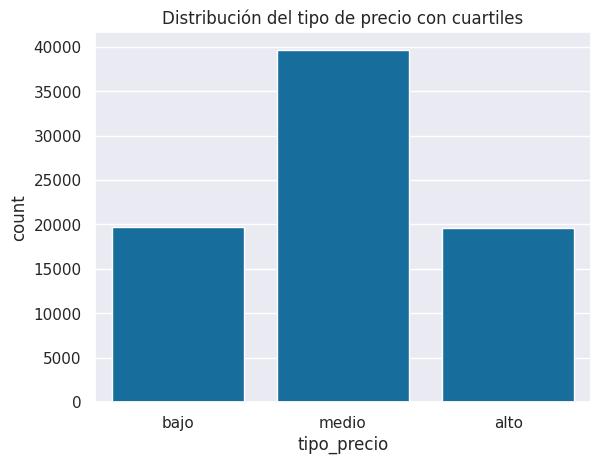

In [431]:
bins_q1_y_q3 = pd.DataFrame({ "property_type": df.loc[precios_bins_q1_y_q3.index, "property_type"], "tipo_precio":  precios_bins_q1_y_q3})
sns.countplot(data=bins_q1_y_q3, x="tipo_precio").set(title="Distribución del tipo de precio con cuartiles")

Nuevamente, podemos desgranar esta distribución para ver cómo se repartieron los diferentes tipos de propiedades en estas categorías.

Text(0.5, 1.0, 'Distribución de tipos de precios según el tipo de propiedad')

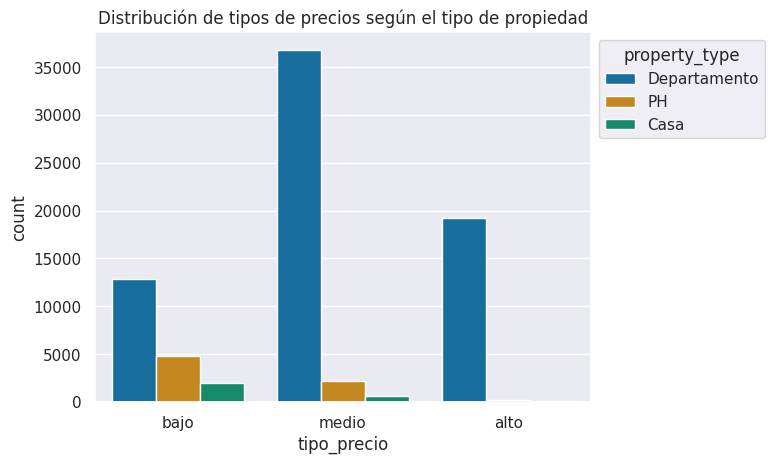

In [432]:
ax = sns.countplot(data=bins_q1_y_q3, x="tipo_precio", hue="property_type")
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.title("Distribución de tipos de precios según el tipo de propiedad")

Finalmente, para el tercer caso, donde hacemos la división de precios por cada categoría, podemos visualizar las tres distribuciones en conjunto. Si bien los bins de los tipos de precio para los departamentos tienen muchas más muestras (esto debido a que en si mismo los departamentos abarcan más de un 85% del total de las propiedades), podemos notar cómo tanto para las casas como para los PHs, también se mantienen las proporciones entre la cantidad de muestras por grupo.

<Axes: xlabel='tipo_precio', ylabel='count'>

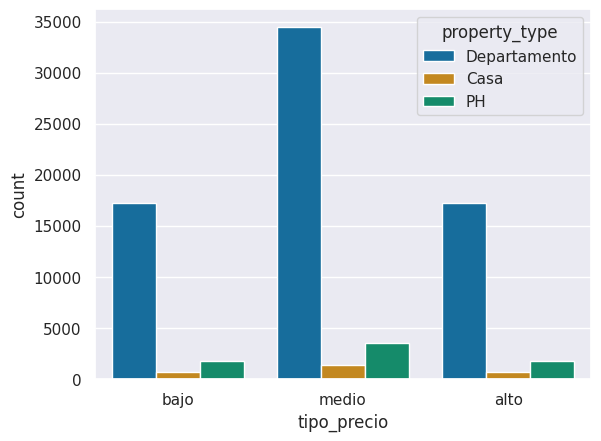

In [433]:
fig, ax = plt.subplots()

deptos = pd.DataFrame()
deptos["tipo_precio"] = precios_bins_departamentos
deptos = deptos.assign(property_type="Departamento")

casas = pd.DataFrame()
casas["tipo_precio"] = precios_bins_casas
casas = casas.assign(property_type="Casa")

phs = pd.DataFrame()
phs["tipo_precio"] = precios_bins_phs
phs = phs.assign(property_type="PH")

bins_por_tipo_prop = pd.concat([deptos, casas, phs])

sns.countplot(data=bins_por_tipo_prop, x="tipo_precio", hue="property_type", dodge=True)

Verificamos la distribución para cada tipo de propiedad de forma numérica además de forma visual:

In [434]:
precios_bins_departamentos.value_counts()

precio_m2
medio    34481
bajo     17263
alto     17236
Name: count, dtype: int64

In [435]:
precios_bins_casas.value_counts()

precio_m2
medio    1397
bajo      698
alto      694
Name: count, dtype: int64

In [436]:
precios_bins_phs.value_counts()

precio_m2
medio    3566
bajo     1783
alto     1782
Name: count, dtype: int64

Tal y como se deseaba, para cada tipo de propiedad la categoría de precios medios tiene el doble de muestras que las otras dos.

La forma que seleccionamos para definir los límites de cada categoría es la tercera, en donde tenemos en cuenta el tipo de las propiedades. Como se puede ver en el siguiente gráfico, la cantidad de departamentos es muy superior a la cantidad de casas y PHs. Si no tenemos en cuenta el tipo de propiedad a la hora de categorizar, los departamentos tendrían mucho más peso sobre ella que las casas y los PHs.

In [437]:
df.loc[df['property_type'] == 'Casa', 'tipo_precio'] = precios_bins_casas
df.loc[df['property_type'] == 'PH', 'tipo_precio'] = precios_bins_phs
df.loc[df['property_type'] == 'Departamento', 'tipo_precio'] = precios_bins_departamentos

### Comparación con KMeans

Notamos que a diferencia que cuando usamos KMeans con 3 grupos, la forma elegida para hacer la división de los tipos de precio hace que el grupo que contiene los precios intermedios sea el más numeroso. Sin embargo, cuando usamos KMeans, los otros dos clusters eran mucho más pequeños, y no llegaban a contener el 25% de los datos.

- first_cluster es el de los precios medios
- second_cluster es el de los precios bajos
- third_cluster es el de los precios altos

In [438]:
len(first_cluster), len(second_cluster), len(third_cluster)

(15977, 59222, 3701)

In [439]:
len(df[df["tipo_precio"] == "bajo"]),  len(df[df["tipo_precio"] == "medio"]),  len(df[df["tipo_precio"] == "alto"])

(19744, 39444, 19712)

Otra diferencia muy clara es que cuando hicimos KMeans, la distribución de los tipos de propiedades era distinta en cada cluster. Incluso, en el cluster de precios más altos, había un 87% de departamentos. Usando este otro método, nos aseguramos que la distribución de tipos de propiedades de cada grupo sea exactamente la misma.

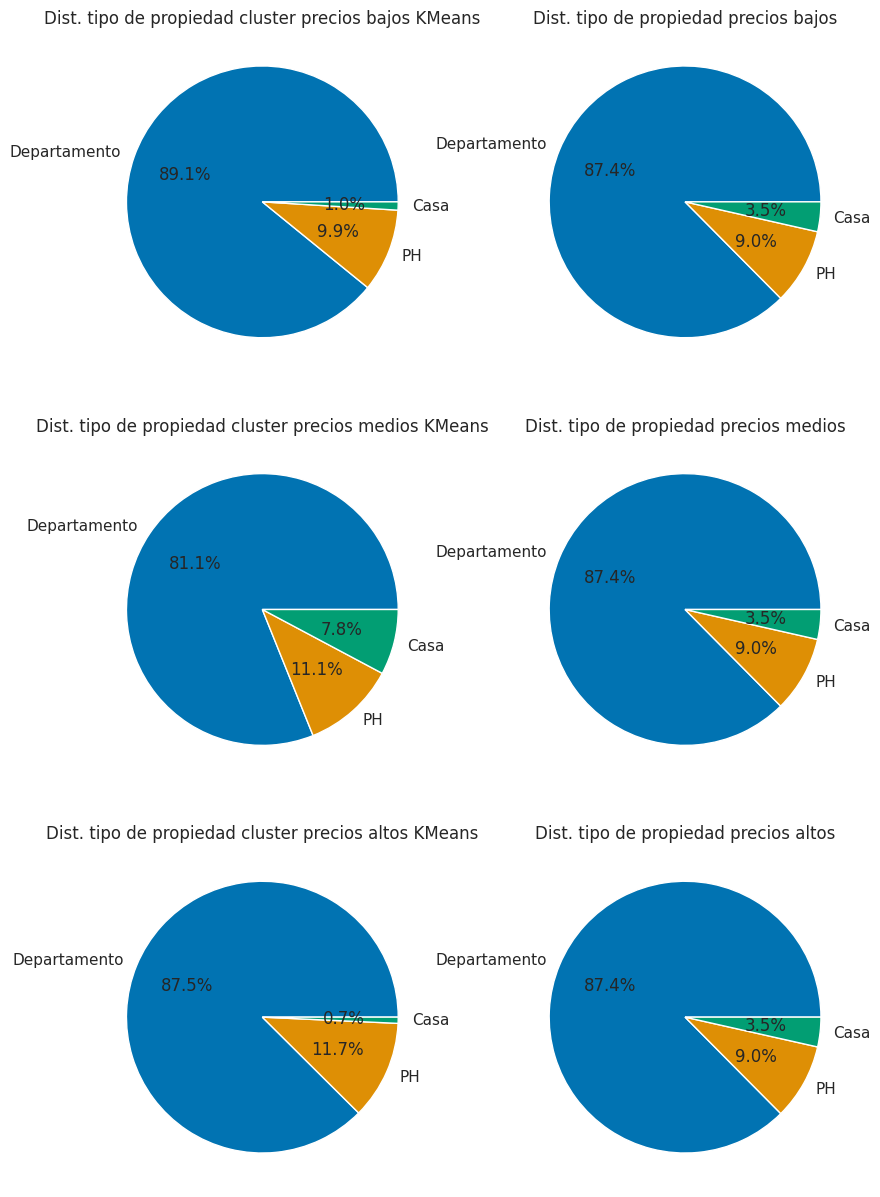

In [443]:
fig, axs =  plt.subplots(3, 2, figsize=(10, 15))
labels = df["property_type"].value_counts().index

axs[0, 0].pie(second_cluster["property_type"].value_counts(), labels=labels, autopct="%1.1f%%")
axs[0, 0].set_title("Dist. tipo de propiedad cluster precios bajos KMeans")

axs[1, 0].pie(first_cluster["property_type"].value_counts(), labels=labels, autopct="%1.1f%%")
axs[1, 0].set_title("Dist. tipo de propiedad cluster precios medios KMeans")

axs[2, 0].pie(third_cluster["property_type"].value_counts(), labels=labels, autopct="%1.1f%%")
axs[2, 0].set_title("Dist. tipo de propiedad cluster precios altos KMeans")

axs[0, 1].pie(df[df["tipo_precio"] == "bajo"]["property_type"].value_counts(), labels=labels, autopct="%1.1f%%")
axs[0, 1].set_title("Dist. tipo de propiedad precios bajos")

axs[1, 1].pie(df[df["tipo_precio"] == "medio"]["property_type"].value_counts(), labels=labels, autopct="%1.1f%%")
axs[1, 1].set_title("Dist. tipo de propiedad precios medios")

axs[2, 1].pie(df[df["tipo_precio"] == "alto"]["property_type"].value_counts(), labels=labels, autopct="%1.1f%%")
axs[2, 1].set_title("Dist. tipo de propiedad precios altos")

plt.show()

Finalmente, mostramos en un mapa las localizaciones de las propiedades coloreadas según su respectivas categoría de precio.

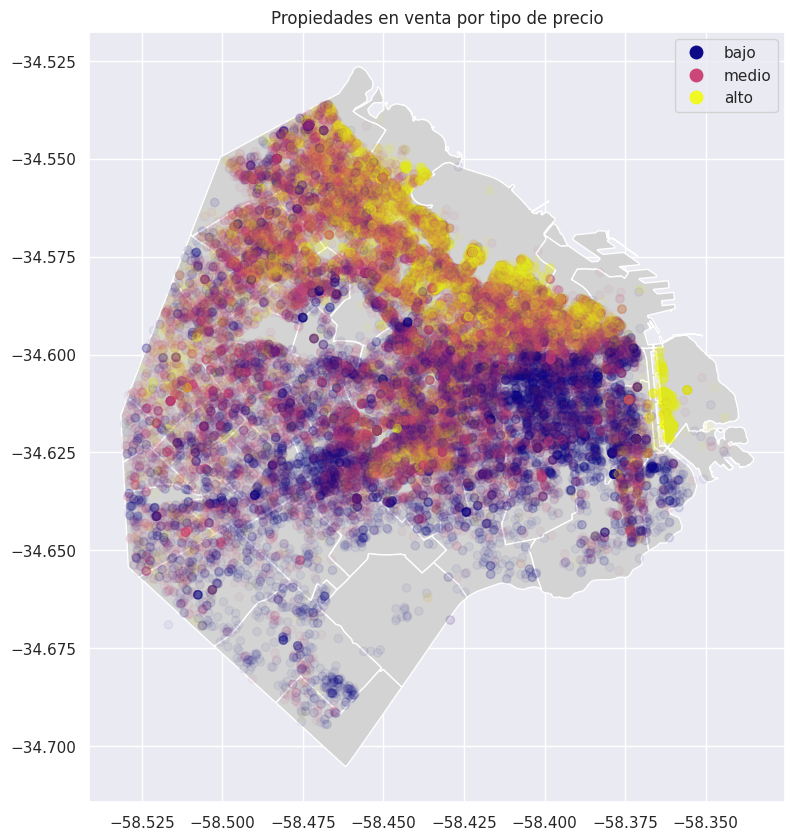

In [441]:
show_map(
  df,
  column_to_plot='tipo_precio',
  title='Propiedades en venta por tipo de precio',
  show_legend=True
)

## Entrenamiento y predicción

Para el entrenamiento de los modelos de clasificación optamos por separar el trabajo en 3 notebooks diferentes, para que así cada una de ellas pudiera ser entrenada en simultáneo. Para eso decidimos guardar el dataset con todas las modificaciones aplicadas para cargarlo manualmente en cada una de los notebooks nuevas.

In [575]:
df.to_csv("df_tipo_precios.csv")

Link del dataframe: https://drive.google.com/file/d/1GhsJwy29gS2y_HibaDeChkx-ozSc2Qc3/view?usp=drive_link